## UC Berkeley Master of Information and Data Science Student Project
Course: W207 Applied Machine Learning<br>
Instructor: Cornelia Ilin

#### Group Members: Andre Gigena,  Jordan Lewis, and Dakota Potere-Ramos

### `Objectives`
- Demonstrate learned capabilities and understanding in machine learning skills and techniques
- Accurately predict room occupancy using non-intrusive sensors to aid first responders in locating occupants during emergencies.

### `Data`
[Source and data description](https://archive.ics.uci.edu/ml/datasets/Room+Occupancy+Estimation): The data comes from the UCI Machine learning repository from a study conducted at IIIT Hyderabad. Room occupancy numbers were collected as well as data from five different types of sensors: temperature, light, CO2, sound, and motion. While other devices such as video might yield better results for determining room occupancy, the sensors used in this study are non-intrusive so they protect the privacy of individuals which would make them more readily adoptable.

# Imports and Installs

In [1]:
!pip install -U tensorflow_addons --quiet
!pip install shap --quiet

In [ ]:
# Standard Libraries
from collections import namedtuple
import datetime
import itertools
import os, sys
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display

# Anaconda
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker
import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.plotting import heatmap
import graphviz

# TensorFlow
import tensorflow as tf
import tensorflow_addons as tfa
tf.config.experimental.enable_op_determinism()

# Neural net Explainability
import shap

In [3]:
# For Andre only
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/207 - Applied Machine Learning/project_repo

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/207 - Applied Machine Learning/project_repo


In [3]:
# Definition used for hyperparameter tuning
HP_FACTOR = namedtuple("HP_FACTOR", ["name", "values"])

# Initial EDA and Feature Engineering

In [4]:
# Get current working directory for repo
working_dir = os.getcwd()

In [2]:
# Load data
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv")
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [ ]:
## Alternative method to load data if running from clone of github repo
# read the original / raw Occupancy_Estimation.csv data source
df = pd.read_csv(working_dir + '/data/raw/Occupancy_Estimation.csv')
df.head()

In [7]:
# ID original features and labels
print('Total number of columns:', len(df.columns))
features = df.columns[:18]
print('Original Features:', features)
label = [df.columns[-1]]
print('Original Label:', label)
print('Class labels:', df[label[0]].unique())
print('Original Shape:', df.shape)

Total number of columns: 19
Original Features: Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'],
      dtype='object')
Original Label: ['Room_Occupancy_Count']
Class labels: [1 2 3 0]
Original Shape: (10129, 19)


In [8]:
# Display the number of fields in each column
df.count()

Date                    10129
Time                    10129
S1_Temp                 10129
S2_Temp                 10129
S3_Temp                 10129
S4_Temp                 10129
S1_Light                10129
S2_Light                10129
S3_Light                10129
S4_Light                10129
S1_Sound                10129
S2_Sound                10129
S3_Sound                10129
S4_Sound                10129
S5_CO2                  10129
S5_CO2_Slope            10129
S6_PIR                  10129
S7_PIR                  10129
Room_Occupancy_Count    10129
dtype: int64

In [9]:
# Identify the type of each column
df.dtypes

Date                     object
Time                     object
S1_Temp                 float64
S2_Temp                 float64
S3_Temp                 float64
S4_Temp                 float64
S1_Light                  int64
S2_Light                  int64
S3_Light                  int64
S4_Light                  int64
S1_Sound                float64
S2_Sound                float64
S3_Sound                float64
S4_Sound                float64
S5_CO2                    int64
S5_CO2_Slope            float64
S6_PIR                    int64
S7_PIR                    int64
Room_Occupancy_Count      int64
dtype: object

In [10]:
# Identify whether the data has any missing values
df.isna().sum()

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

In [11]:
# Create a more user-friendly "Timestamp" feature from "Date" and "Time" columns
timestamp = pd.to_datetime(df["Date"].astype(str) + df["Time"], format="%Y/%m/%d%H:%M:%S")
df.insert(0, "Timestamp", timestamp)

In [12]:
# General statistics of the data
df.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


In [13]:
# Drop previous date and time columns
df.drop(columns=["Date", "Time"], inplace=True)

# Add occupied bool as potential output for EDA only
df["Occupied"] = (df["Room_Occupancy_Count"] > 0).astype(int)

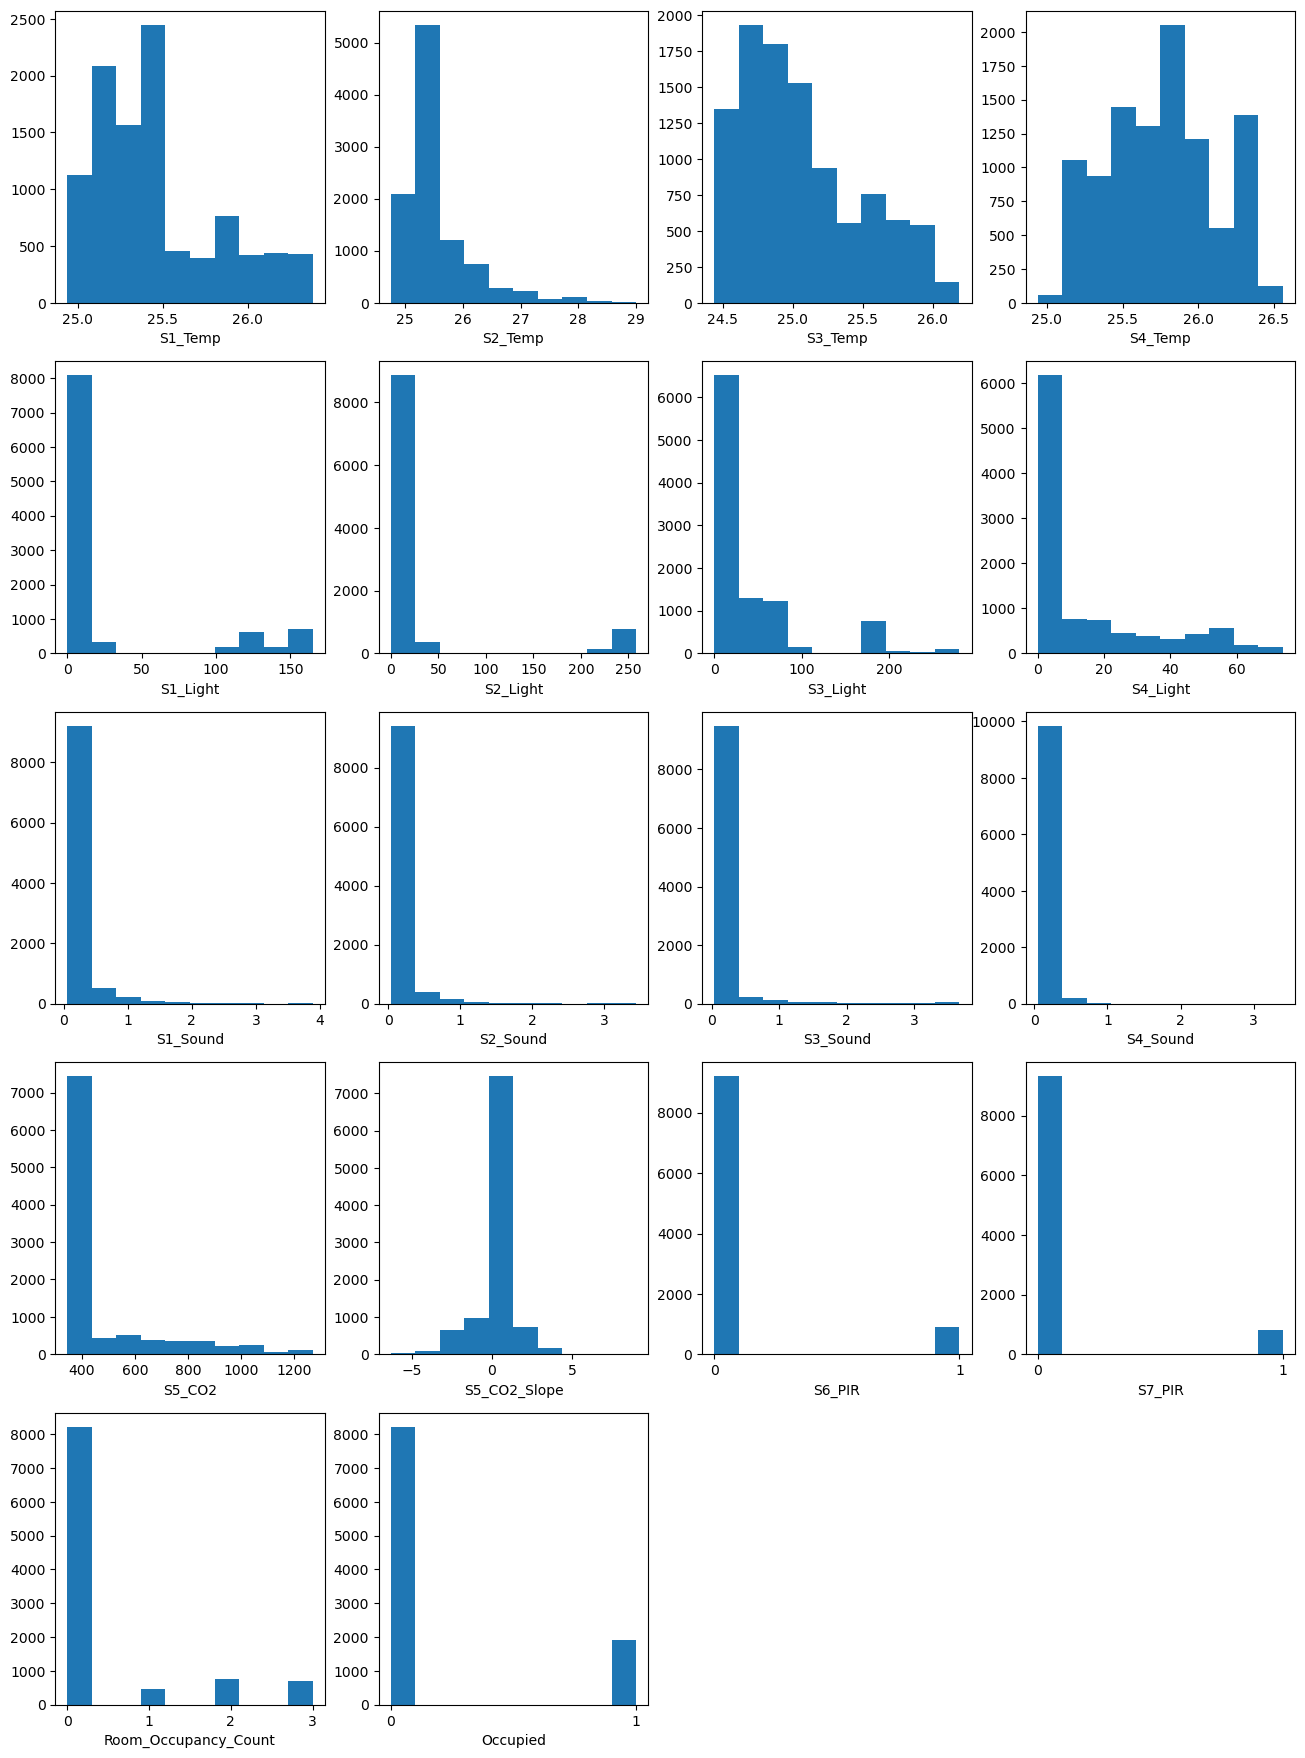

In [14]:
# Create Histograms for features to visualize distributions
columns = df.columns[1:]

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16,22))
for idx, ax in enumerate(axes.flatten()):
    if idx >= len(columns):
        break
    # plot histogram
    ax.hist(df[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])
axes[4][2].remove()
axes[4][3].remove()
axes[3][2].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
axes[3][3].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
axes[4][1].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

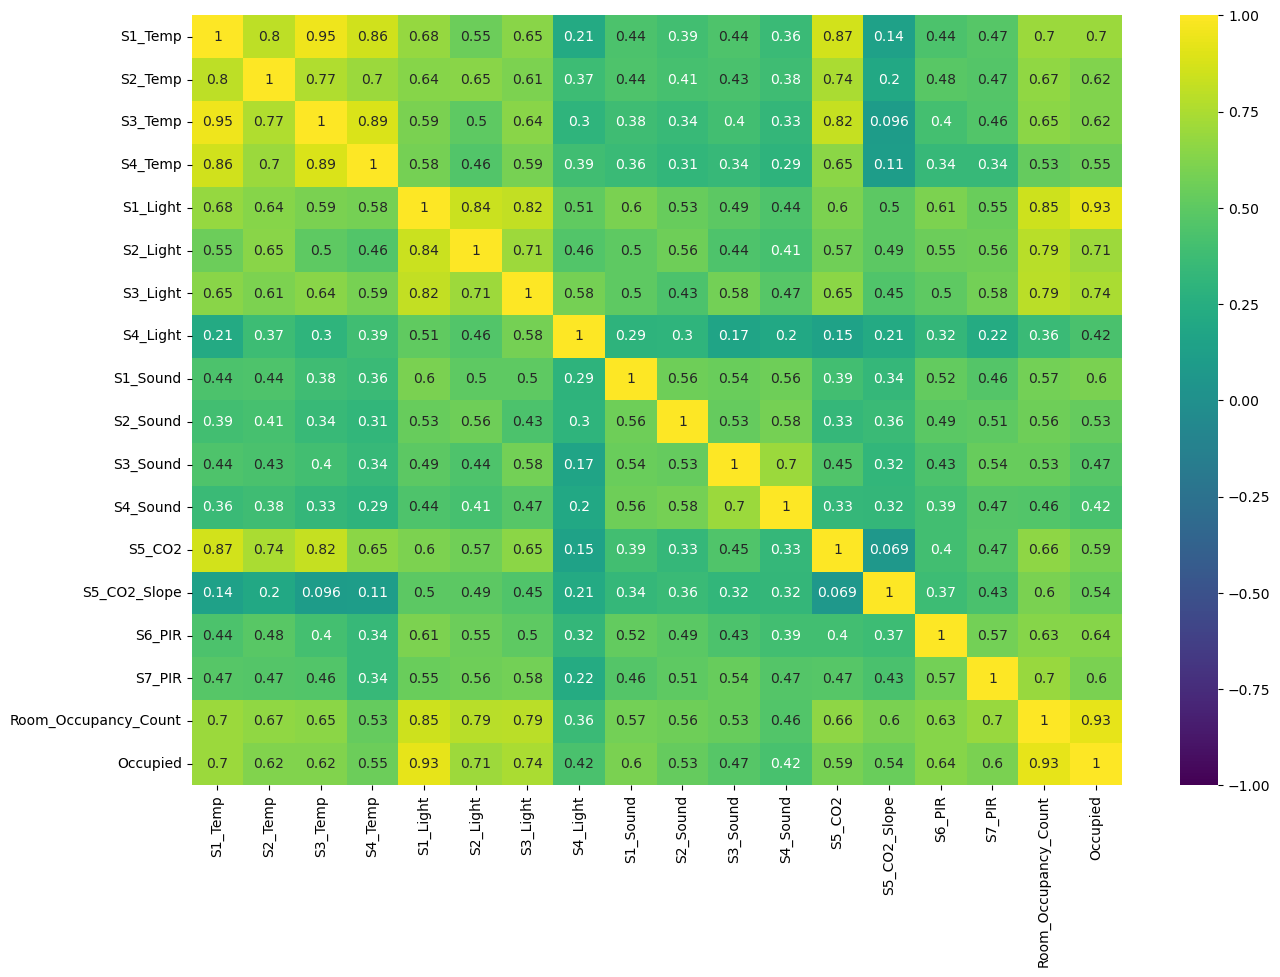

In [16]:
# Correlation of all the columns in the dataframe
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(data=df.corr(), vmin=-1, vmax=1, cmap="viridis", annot=True, ax=ax)
plt.show()

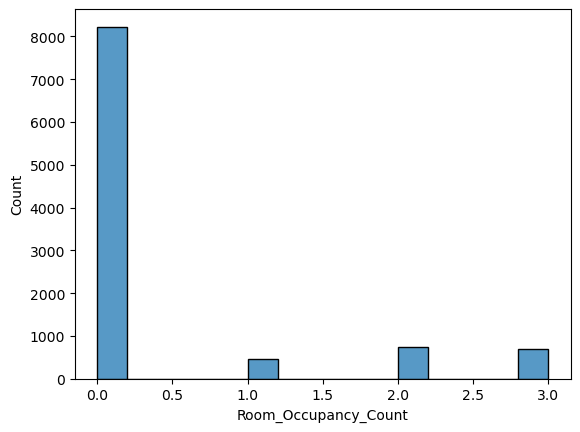

In [17]:
# Explore the distribution of classes
sns.histplot(df["Room_Occupancy_Count"])
plt.show()

In [18]:
# Explore the details of when rooms are empty/occupied
min_occupied_time = df[df["Room_Occupancy_Count"].ge(1)]["Timestamp"].dt.time.min()
max_occupied_time = df[df["Room_Occupancy_Count"].ge(1)]["Timestamp"].dt.time.max()

min_unoccupied_time = df[df["Room_Occupancy_Count"] == 0]["Timestamp"].dt.time.min()
max_unoccupied_time = df[df["Room_Occupancy_Count"] == 0]["Timestamp"].dt.time.max()

print(f"Min/Max Occupied Time: {min_occupied_time}/{max_occupied_time}")
print(f"Min/Max Unoccupied Time: {min_unoccupied_time}/{max_unoccupied_time}")

Min/Max Occupied Time: 10:49:41/19:51:46
Min/Max Unoccupied Time: 00:00:28/23:59:58


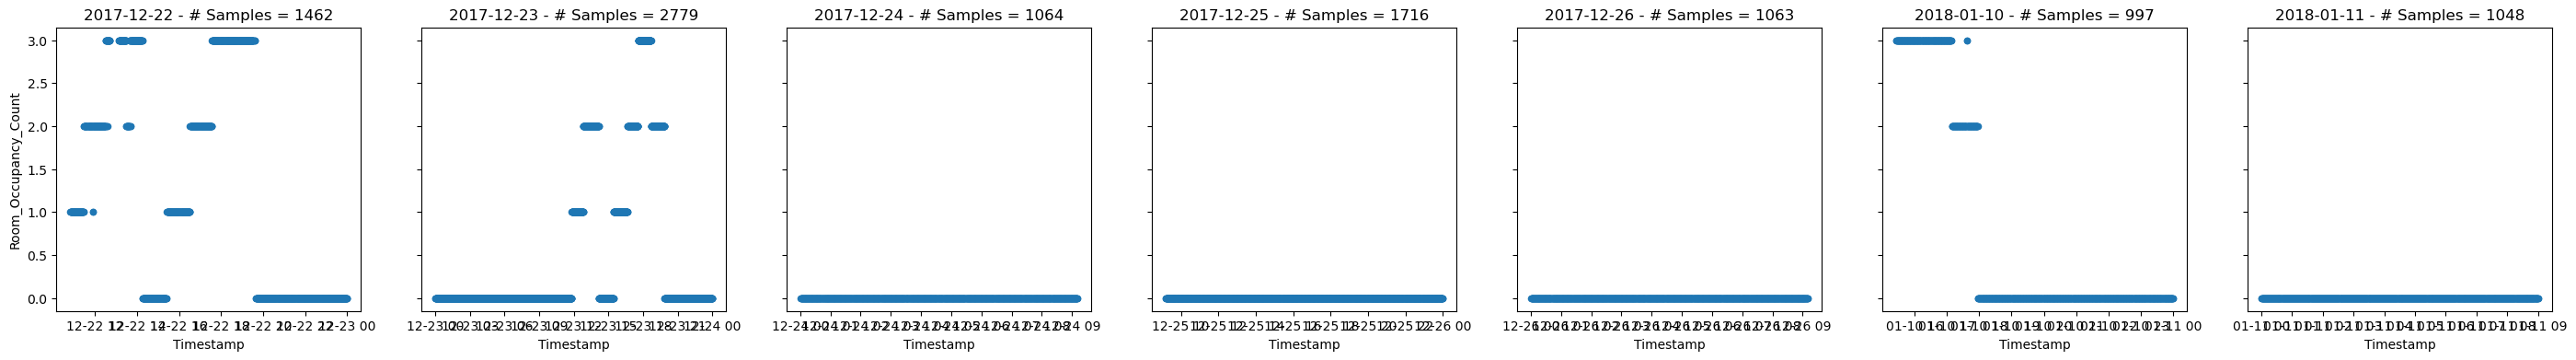

In [19]:
# Visualize when rooms are empty/occupied
fig, axes = plt.subplots(1, df["Timestamp"].dt.date.nunique(), sharey=True, figsize=(35, 4))

for date, ax in zip(df["Timestamp"].dt.date.unique(), axes):
    subset = df[df["Timestamp"].dt.date == date]
    subset.plot(x="Timestamp", y="Room_Occupancy_Count", kind="scatter", ax=ax)
    ax.set_title(f"{date} - # Samples = {len(subset)}")
plt.show()

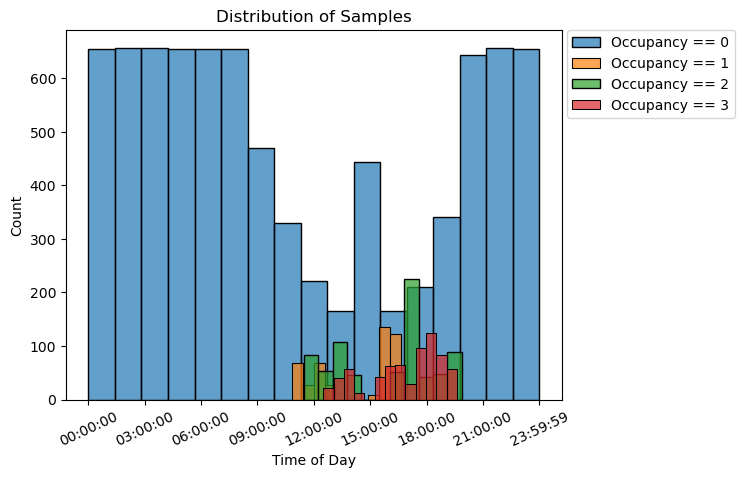

In [20]:
# Plot count of samples by occupancy and time
def time_to_seconds(x):
    """ Function for converting datetime.time object to seconds since midnight """
    return (x.hour * 60 + x.minute) * 60 + x.second


seconds = df["Timestamp"].dt.time.apply(time_to_seconds)

for occupancy_count in sorted(df["Room_Occupancy_Count"].unique()):
    sns.histplot(
        data=seconds[df.Room_Occupancy_Count.eq(occupancy_count)],
        label=f"Occupancy == {occupancy_count}",
        alpha=0.7
    )

x_labels = [datetime.time(i, 0, 0) for i in range(0, 22, 3)] + [datetime.time(23, 59, 59)]
x_ticks = [time_to_seconds(i) for i in x_labels]
plt.xticks(ticks=x_ticks, labels=x_labels, rotation=25)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)
plt.xlabel("Time of Day")
plt.title("Distribution of Samples")
plt.show()

Total count of records after downsampling: 3590
Value counts for each class after downsampling:
0    1689
2     748
3     694
1     459
Name: Room_Occupancy_Count, dtype: int64


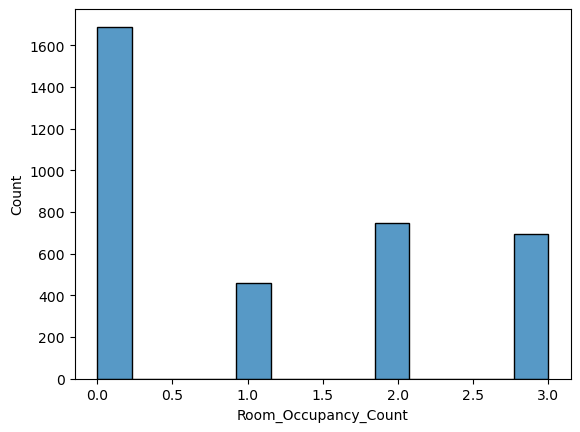

In [21]:
# Attempt to correct for class imbalance of Room_Occupancy_Count
# Downsample the majority class (Room_Occupancy_Count == 0)
# by keeping only records between the min_occupied_time and max_occupied_time 

# determine number of records remainging after downsampling the majority class
record_count_after_filter = df[df["Timestamp"].dt.time.between(min_occupied_time, max_occupied_time)]["Room_Occupancy_Count"].count()
print('Total count of records after downsampling:', record_count_after_filter)
room_occupancy_value_count_after_filter = df[df["Timestamp"].dt.time.between(min_occupied_time, max_occupied_time)]["Room_Occupancy_Count"].value_counts()
print('Value counts for each class after downsampling:')
print(room_occupancy_value_count_after_filter)

sns.histplot(df[df["Timestamp"].dt.time.between(min_occupied_time, max_occupied_time)]["Room_Occupancy_Count"])
plt.show()

# Model Pipeline

## Helper Functions, Load Data, Preprocessing and Feature Engineering

### Define General Helper Functions

In [3]:
def split_data(X, y, split=(0.6, 0.2, 0.2), random_seed=888):
    """
    Splits X/y into training, validation, and testing sets based on the
    specified split.

    Parameters
    ----------
    X : np.ndarray
        An array-like collection of sample points
    y : np.ndarray
        The class labels of the data, should match the length of data
    split : tuple
        The percentage allocation of training, validation, and test datasets
        Default: (0.6, 0.2, 0.2)
    random_seed : int
        The seed for the random number generator
        Default: 888

    Returns
    -------
    splits : tuple
        The training, validation, and test datasets with their labels
    """
    # Input checking
    if len(X) != len(y):
        raise ValueError(f"X and y lengths don't match ({len(X)} != {len(y)})")
    if len(split) != 3:
        raise ValueError("Invalid split, expected 3 percentages (training, validation, test)")
    if sum(split) != 1:
        raise ValueError(f"Invalid split {split}, percentages must sum to 1!")
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("X and y must be numpy arrays")

    # Initial split for testing data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=split[2], random_state=random_seed, stratify=y
    )

    # Further split for validation data
    val_size = split[1] / (1 - split[2])
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=random_seed, stratify=y_train
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
def calculate_f1_scores(true_labels, predicted_labels, labels=[0, 1, 2, 3], print_output=True):
    """
    Calculates the macro average f1-score, micro average f1-score, and weighted
    average f1-score from the given true and predicted labels

    Parameters
    ----------
    true_labels : np.ndarray
        An array-like collection of the true labels a model is trying to predict
    predicted_labels : np.ndarray
        An array-like collection of the predicted labels output from a model
    labels : list
        The set of unique class labels in the given classification problem
        Default: [0, 1, 2, 3]
    print_output : bool
        Whether to print the metrics out or not
        Default : True

    Returns
    -------
    macro_avg_f1 : float
        The macro average f1-score for the model. The function calculates the f1-score
        for each class individually and takes the unweighted mean of all values    
    micro_avg_f1 : float
        The micro average f1-score for the model. The function considers the total
        True Negatives (TN) and total False Positives (FP) amongst all classes and
        calculates the f1-score globally for the model
    weighted_avg_f1: float
        The support weighted average f1-score for the model. The function calculates
        the f1-score for each class individually and takes the weighted mean of all
        values based on the support of each class
    """

    # Calculate metrics
    macro_avg_f1 = f1_score(true_labels, predicted_labels, labels=labels, average="macro")
    micro_avg_f1 = f1_score(true_labels, predicted_labels, labels=labels, average="micro")
    weighted_avg_f1 = f1_score(true_labels, predicted_labels, labels=labels, average="weighted")

    # Print metrics
    if print_output:
        print("F1-Scores")
        print("---------")
        print(f"Macro average: {macro_avg_f1:9.4f}")
        print(f"Micro average: {micro_avg_f1:9.4f}")
        print(f"Weighted average: {weighted_avg_f1:.4f}\n")

    return macro_avg_f1, micro_avg_f1, weighted_avg_f1

In [5]:
def plot_history(history, save_path=None, save_kwgs={}):
    """
    Plots the training/validation loss for a TensorFlow model

    Parameters
    ----------
    history : pandas DataFrame
        The dataframe of history from the TensorFlow model fit step
    save_path : str
        The path to which to save the image
        Default : None (no output saved)
    save_kwgs : dict
        A dictionary mapping plt.savefig arguments to values
        Default : {}
    """
    plt.plot(history["loss"], label="Training", marker="o", color="#e03636")
    plt.plot(history["val_loss"], label="Validation", marker="o", ls="--", color="#595e93")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, **save_kwgs)

    plt.show()

In [6]:
def plot_roc(y_true, y_pred_prob, n_classes=4, save_path=None, save_kwgs={}):
    """
    Plots the ROC curve for the given data and includes the macro-averaged
    AUC score for each class in the plot label

    Parameters
    ----------
    y_true : array_like
        The one-hot encoded true labels
    y_pred_prob : array_like
        The predicted probabilities out of the ML model
    n_classes : int
        The number of classes in the classification problem
        Default : 4
    save_path : str
        The path to which to save the image
        Default : None (no output saved)
    save_kwgs : dict
        A dictionary mapping plt.savefig arguments to values
        Default : {}
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    for class_id in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, class_id],  y_pred_prob[:, class_id])
        auc = roc_auc_score(y_true[:, class_id],  y_pred_prob[:, class_id])
        ax.plot(fpr, tpr, label=f"Occupancy=={class_id} (AUC = {auc:0.3f})", alpha=0.7)

    ax.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.5)")

    ax.axis("square")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("One-vs-Rest ROC Curves")
    ax.legend()

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, **save_kwgs)

    plt.show()

### Load and Prepare Data

In [ ]:
# Load data
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv")

# Combine "Date" and "Time" columns into a single timestamp
timestamp = pd.to_datetime(df["Date"].astype(str) + df["Time"], format="%Y/%m/%d%H:%M:%S")
df.insert(0, "Timestamp", timestamp)
df.drop(columns=["Date", "Time"], inplace=True)

# Save feature and target names
features = df.columns[:-1]
labels = df.columns[-1]

# Convert dataframe into numpy arrays of data
X = df[features].values
y = df[labels].values

# Split data into train/validation/test sets with default 60/20/20 split
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

## Correct class imbalance of Room_Occupancy_Count in training data
# Downsample to time windows where rooms are occupied due to class imbalance
min_occupied_time = df[df["Room_Occupancy_Count"] == 1]["Timestamp"].dt.time.min()
max_occupied_time = df[df["Room_Occupancy_Count"] == 1]["Timestamp"].dt.time.max()

mask_func = np.vectorize(lambda x: (x.time() > min_occupied_time) & (x.time() < max_occupied_time))
mask = mask_func(X_train[:, 0])

X_train = X_train[mask]
y_train = y_train[mask]

# Downsampling done, no longer need "Timestamp" feature 
features = features[1:]
X_train = X_train[:, 1:]
X_val = X_val[:, 1:]
X_test = X_test[:, 1:]

# Helpful variables
n_features = len(features)
n_classes = df[labels].nunique()

# Concatenate train and val subsets into one set for post hyperparameter tuning training
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

# Standardize data
std_scaler = StandardScaler()

X_train_std = std_scaler.fit(X_train).transform(X_train)
X_val_std = std_scaler.fit(X_train).transform(X_val)
X_test_std = std_scaler.fit(X_train).transform(X_test)

X_train_val_std = std_scaler.fit(X_train_val).transform(X_train_val)
X_train_val_test_std = std_scaler.fit(X_train_val).transform(X_test)

# One-hot encoding of target variables
y_train_ohe = tf.one_hot(indices=y_train, depth=n_classes)
y_val_ohe = tf.one_hot(indices=y_val, depth=n_classes)
y_test_ohe = tf.one_hot(indices=y_test, depth=n_classes)
y_train_val_ohe = tf.one_hot(indices=y_train_val, depth=n_classes)

### EDA

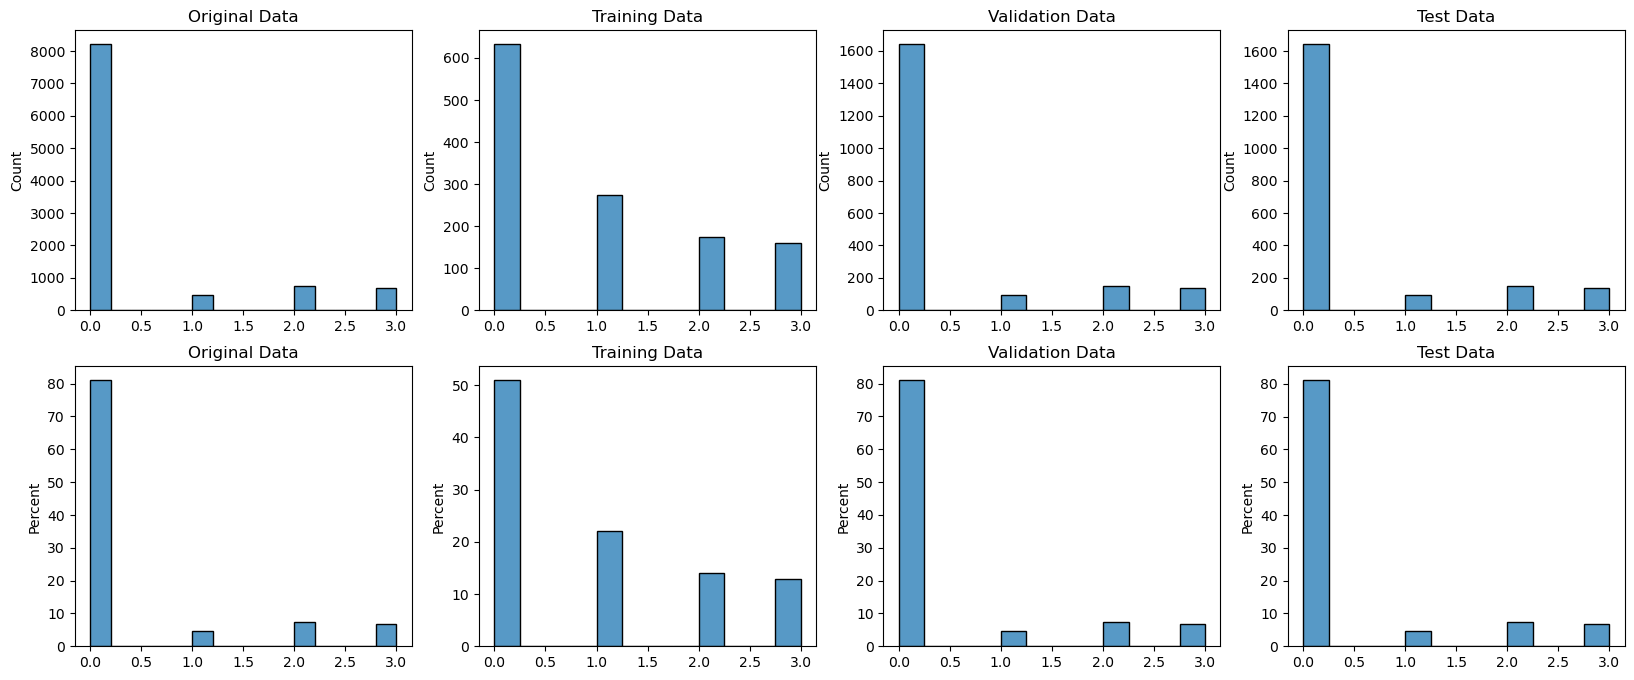

Length of original dataset: 10129

Length of X_train/y_train: 1242/1242
Length of X_val/y_train: 2026/2026
Length of X_test/y_train: 2026/2026

Resulting split: (0.12, 0.20, 0.20)


In [30]:
# Plot showing final distribution of data by class
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

sns.histplot(df[labels], ax=axes[0, 0])
sns.histplot(y_train, ax=axes[0, 1])
sns.histplot(y_val, ax=axes[0, 2])
sns.histplot(y_test, ax=axes[0, 3])

sns.histplot(df[labels], stat="percent", ax=axes[1, 0])
sns.histplot(y_train, stat="percent", ax=axes[1, 1])
sns.histplot(y_val, stat="percent", ax=axes[1, 2])
sns.histplot(y_test, stat="percent", ax=axes[1, 3])

for ax, label in zip(axes[0], ["Original Data", "Training Data", "Validation Data", "Test Data"]):
    ax.set_title(label)
for ax, label in zip(axes[1], ["Original Data", "Training Data", "Validation Data", "Test Data"]):
    ax.set_title(label)

for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

print(f"Length of original dataset: {len(X)}")
print()
print(f"Length of X_train/y_train: {len(X_train)}/{len(y_train)}")
print(f"Length of X_val/y_train: {len(X_val)}/{len(y_val)}")
print(f"Length of X_test/y_train: {len(X_test)}/{len(y_test)}")
print()
print(f"Resulting split: ({len(X_train)/len(X):.2f}, {len(X_val)/len(X):.2f}, {len(X_test)/len(X):.2f})")

## Baseline Model

Training Results:
F1-Scores
---------
Macro average:    0.1690
Micro average:    0.5105
Weighted average: 0.3450

Validation Results:
F1-Scores
---------
Macro average:    0.2241
Micro average:    0.8119
Weighted average: 0.7277

Test Results:
F1-Scores
---------
Macro average:    0.2241
Micro average:    0.8124
Weighted average: 0.7284



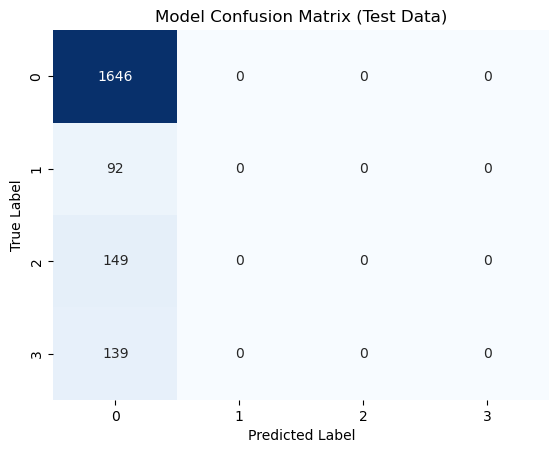

In [31]:
## Create baseline model
# Baseline model always predicts Room_Occupancy_Count == 0
baseline_train_pred = np.zeros(y_train.shape)
baseline_val_pred = np.zeros(y_val.shape)
baseline_test_pred = np.zeros(y_test.shape)

## Evaluate baseline model against train, validation, and test data set
# Evaluate model by calculating Macro, Micro, and Weighted F1-scores
# Calculate F1-scores
print('Training Results:')
calculate_f1_scores(y_train, baseline_train_pred)

print('Validation Results:')
calculate_f1_scores(y_val, baseline_val_pred)

print('Test Results:')
calculate_f1_scores(y_test, baseline_test_pred)

# Create confusion matrix for actual and baseline predictions of y_test
conf_mat_baseline = sklearn.metrics.confusion_matrix(y_test, baseline_test_pred)
conf_mat_baseline = sns.heatmap(conf_mat_baseline, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Model Confusion Matrix (Test Data)')
plt.show()

## Decision Trees

### Define Decision Trees Helper Functions

In [32]:
def get_decision_tree(criterion='gini', max_depth=None, print_output=True):
    """
    Automates the process of creating a decision tree, calculating the f1 scores of the model,
    displaying the model's confusion matrix, identifying the features used in the model and their importance,
    and visualizing the decision tree with graphviz 

    Parameters
    ----------
    criterion : str, {'gini', 'entropy', 'log_loss'}, default='gini'
        the function to measure the quality of a split in the decision tree classifier
    max_depth : int, default=None
        The maximum depth of a the decision tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

    Returns
    -------
    macro_f1_tree_train : float
        The macro average f1-score for the model when predicting the training data. 
    micro_f1_tree_train : float
        The micro average f1-score for the model when predicting the training data. 
    weighted_f1_tree_train: float
        The support weighted average f1-score for the model when predicting the training data.
    macro_f1_tree_val : float
        The macro average f1-score for the model when predicting the validation data. 
    micro_f1_tree_val : float
        The micro average f1-score for the model when predicting the validation data. 
    weighted_f1_tree_val: float
        The support weighted average f1-score for the model when predicting the validation data.     
    """

    # Capture arguments passed to function
    max_depth = max_depth
    criterion = criterion

    # Instantiate tree classifier
    dt_clf = DecisionTreeClassifier(criterion=criterion, random_state=888, max_depth=max_depth)

    # Fit the model to the training data set
    dt_clf = dt_clf.fit(X_train, y_train)

    # Predict the training data and probabilities
    y_train_pred = dt_clf.predict(X_train)
    y_train_pred_prob = dt_clf.predict_proba(X_train)

    # Predict the validation data and the probabilities
    y_val_pred = dt_clf.predict(X_val)
    y_val_pred_prob = dt_clf.predict_proba(X_val)

    # Calculate training F1-scores
    print('Training Results:')
    macro_f1_tree_train, micro_f1_tree_train, weighted_f1_tree_train = calculate_f1_scores(y_train, y_train_pred)

    # Calculate validation F1-scores
    print('Validation Results:')
    macro_f1_tree_val, micro_f1_tree_val, weighted_f1_tree_val = calculate_f1_scores(y_val, y_val_pred)
    
    if print_output:
        # Create and visualize confusion matrix
        sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Model Confusion Matrix (Validation Data)")
        plt.show()

        # Display the ROC-AUC Curve for the model
        print('ROC-AUC for validation data:')
        display(plot_roc(y_val_ohe, y_val_pred_prob))

        # Identify and display the features selected by the decision tree model and their importance
        df_dt_feature_importance = pd.DataFrame()
        df_dt_feature_importance['Feature'] = features
        df_dt_feature_importance['Feature Importance'] = dt_clf.feature_importances_
        df_dt_feature_importance = df_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
        df_dt_feature_importance = df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]
        print('Number of features used in decision tree:', len(df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]))
        print('Features used in the model and their importance:')
        display(df_dt_feature_importance)
        
        # Use graphviz to visualize the decision tree
        dot_data = tree.export_graphviz(dt_clf, out_file=None,
                                        feature_names=features,
                                        class_names=['0','1','2','3'],
                                        filled=True, rounded=True,
                                        special_characters=True,
                                        # leaves_parallel=True,
                                        )
        graph = graphviz.Source(dot_data, format='svg')
        display(graph)

    return macro_f1_tree_train, micro_f1_tree_train, weighted_f1_tree_train, macro_f1_tree_val, micro_f1_tree_val, weighted_f1_tree_val


### Decision Tree (determine importance of all features with default values)

Training Results:
F1-Scores
---------
Macro average:    1.0000
Micro average:    1.0000
Weighted average: 1.0000

Validation Results:
F1-Scores
---------
Macro average:    0.7114
Micro average:    0.9245
Weighted average: 0.9221



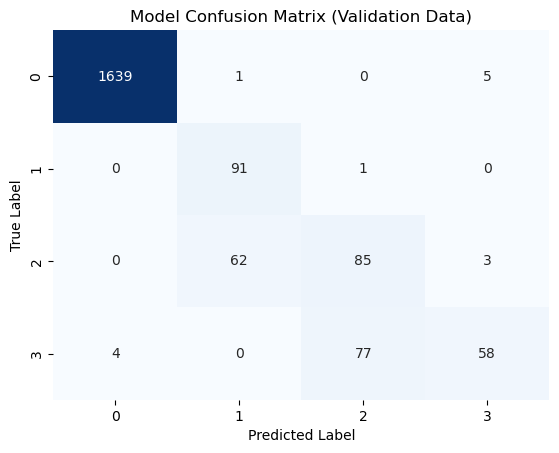

ROC-AUC for validation data:


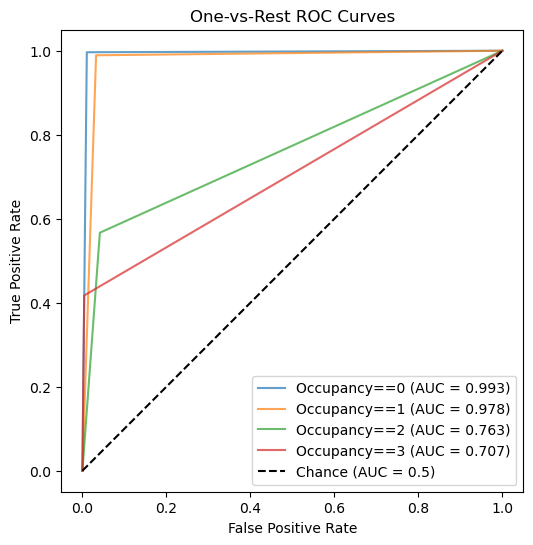

Number of features used in decision tree: 10
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.469596
5,S2_Light,0.243592
6,S3_Light,0.114900
13,S5_CO2_Slope,0.114366
11,S4_Sound,0.021496
9,S2_Sound,0.019850
3,S4_Temp,0.009185
10,S3_Sound,0.003686
7,S4_Light,0.002346
8,S1_Sound,0.000984


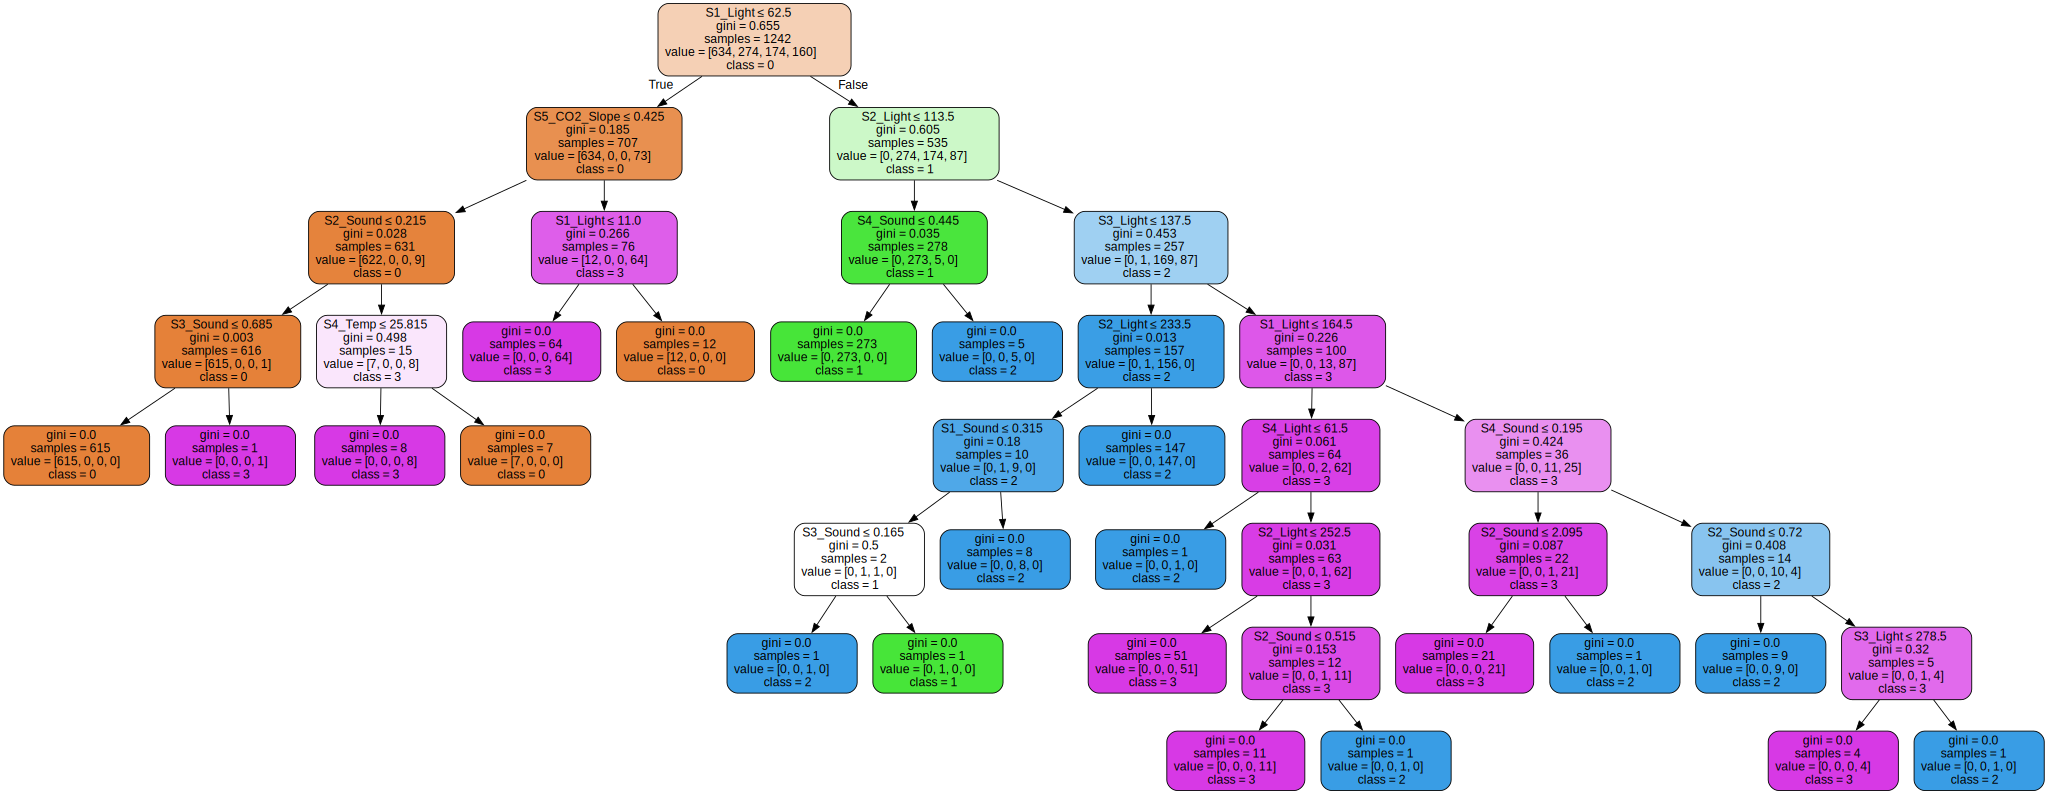

In [33]:
# Instantiate tree classifier
# Use gini impurity as an intermediate measure between entropy and classification error and minimize probability of misclassification
dt_clf = DecisionTreeClassifier(criterion='gini', random_state=888)

# Fit the model to X_train and y_train
dt_clf = dt_clf.fit(X_train, y_train)

# Predict the training data and probabilities
y_train_pred = dt_clf.predict(X_train)
y_train_pred_prob = dt_clf.predict_proba(X_train)

# Predict the validation data and the probabilities
y_val_pred = dt_clf.predict(X_val)
y_val_pred_prob = dt_clf.predict_proba(X_val)

# Calculate F1-scores
print('Training Results:')
calculate_f1_scores(y_train, y_train_pred)

print('Validation Results:')
calculate_f1_scores(y_val, y_val_pred)

# Create and visualize confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix (Validation Data)")
plt.show()

# Display the ROC-AUC Curve for the model
print('ROC-AUC for validation data:')
plot_roc(y_val_ohe, y_val_pred_prob)

# Identify and display the features selected by the decision tree model and their importance
df_dt_feature_importance = pd.DataFrame()
df_dt_feature_importance['Feature'] = features
df_dt_feature_importance['Feature Importance'] = dt_clf.feature_importances_
df_dt_feature_importance = df_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_dt_feature_importance = df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in decision tree:', len(df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_dt_feature_importance)

# Use graphviz to visualize the decision tree
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                                feature_names=features,
                                class_names=['0','1','2','3'],
                                filled=True, rounded=True,
                                special_characters=True,
                                # leaves_parallel=True,
                                )
graph = graphviz.Source(dot_data, format='svg')
display(graph)


### Decision Tree (tune criterion and max_depth hyper parameters)

In [34]:
# Create dataframe to store evaluation metrics of each tree iteration
df_tree_f1s = pd.DataFrame(columns=['Criterion','Tree Depth', 'Val. Macro F1', 'Val. Micro F1', 'Val. Weighted F1'])

## Loop through combos of criterion and max_depth and record macro f1 score on training and validation data to determine optimal values of hyper parameters
# Create lists for each hyper parameter options
max_depths = [1, 2, 3, 4, 5, 6, 7, 8]
criterion = ['gini', 'entropy']

# create combinations of all criterion and max_depths
criterion_depth_combos = list(itertools.product(criterion, max_depths))

# Instantiate lists to hold results
train_results = []
val_results = []

# Loop through combos, print iteration details, capture f1 scores, add results to lists and dataframe for future analysis
for combo in criterion_depth_combos:
    criterion = combo[0]
    depth = combo[1]
    print('-------------------------------------------------------------------------------------------------------------------------')
    print("==========================")
    print("Hyperparameters")
    print("criterion =", criterion)
    print("max_depth =", depth)
    print("==========================")
    macro_f1_tree_train, micro_f1_tree_train, weighted_f1_tree_train, macro_f1_tree_val, micro_f1_tree_val, weighted_f1_tree_val = get_decision_tree(criterion=criterion, max_depth=depth, print_output=False)
    train_results.append(macro_f1_tree_train)
    val_results.append(macro_f1_tree_val)
    df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([[criterion, depth, macro_f1_tree_val, micro_f1_tree_val, weighted_f1_tree_val]], columns=df_tree_f1s.columns)], ignore_index=True)

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = gini
max_depth = 1
Training Results:
F1-Scores
---------
Macro average:    0.4057
Micro average:    0.7311
Weighted average: 0.6321

Validation Results:
F1-Scores
---------
Macro average:    0.3543
Micro average:    0.8569
Weighted average: 0.8196

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = gini
max_depth = 2
Training Results:
F1-Scores
---------
Macro average:    0.8248
Micro average:    0.9082
Weighted average: 0.8999

Validation Results:
F1-Scores
---------
Macro average:    0.6580
Micro average:    0.9107
Weighted average: 0.9060

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = gini
max_depth = 3
Training Results:
F1-Scores
-----

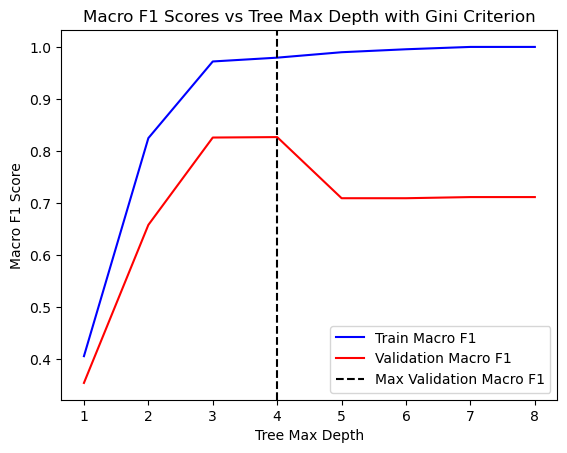

In [35]:
# Plot Macro F1 scores vs max_depth for gini criterion (equivalent of loss curve for decision tree hyperparameter tuning)
line1, = plt.plot(max_depths, train_results[0:len(max_depths)], 'b', label='Train Macro F1')
line2, = plt.plot(max_depths, val_results[0:len(max_depths)], 'r', label='Validation Macro F1')
plt.axvline(x=(val_results[0:len(max_depths)].index(max(val_results[0:len(max_depths)]))+1), color='k', label='Max Validation Macro F1', linestyle='dashed')

plt.legend()
plt.ylabel('Macro F1 Score')
plt.xlabel('Tree Max Depth')
plt.title('Macro F1 Scores vs Tree Max Depth with Gini Criterion')
plt.show()

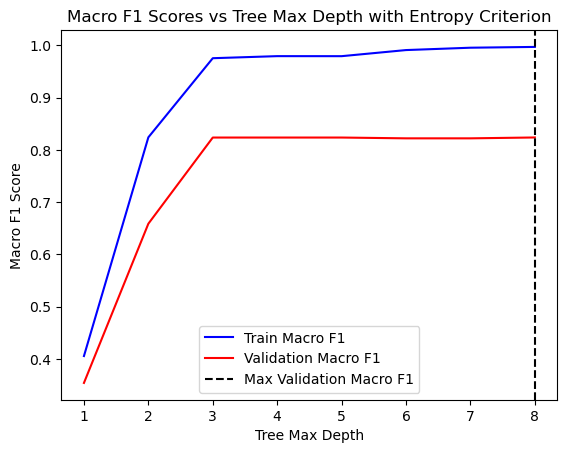

In [36]:
# Plot Macro F1 scores vs max_depth for entropy criterion (equivalent of loss curve for decision tree hyperparameter tuning)
line1, = plt.plot(max_depths, train_results[len(max_depths):], 'b', label='Train Macro F1')
line2, = plt.plot(max_depths, val_results[len(max_depths):], 'r', label='Validation Macro F1')
plt.axvline(x=(val_results[len(max_depths):].index(max(val_results[len(max_depths):]))+1), color='k', label='Max Validation Macro F1', linestyle='dashed')

plt.legend()
plt.ylabel('Macro F1 Score')
plt.xlabel('Tree Max Depth')
plt.title('Macro F1 Scores vs Tree Max Depth with Entropy Criterion')
plt.show()

In [37]:
# Display dataframe that stores F1-scores from each iteration
display(df_tree_f1s)

# print best hyper parameters based on maximum macro f1-score
print('Hyper parameters that maximize macro f1-score in decision tree models:')
print(df_tree_f1s[df_tree_f1s['Val. Macro F1']== df_tree_f1s['Val. Macro F1'].max()].to_string(index=False))



# Output indicates criterion='gini' and max_depth=4 has the optimal F1-scores across the board == Best place to prune.

,Criterion,Tree Depth,Val. Macro F1,Val. Micro F1,Val. Weighted F1
0,gini,1,0.354310,0.856861,0.819636
1,gini,2,0.658010,0.910661,0.905959
2,gini,3,0.825865,0.956071,0.953799
3,gini,4,0.826714,0.956565,0.954259
4,gini,5,0.709255,0.923988,0.921495
5,gini,6,0.709255,0.923988,0.921495
6,gini,7,0.711445,0.924482,0.922105
7,gini,8,0.711445,0.924482,0.922105
8,entropy,1,0.354310,0.856861,0.819636
9,entropy,2,0.658865,0.905726,0.903893


Hyper parameters that maximize macro f1-score in decision tree models:
Criterion Tree Depth  Val. Macro F1  Val. Micro F1  Val. Weighted F1
     gini          4       0.826714       0.956565          0.954259


Thoughts to further tune the model above: https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- Combine train and validation data, retrain / run decision tree
- Try different values for min_samples_split and min_smaples_leaf
    - min_samples_leaf = min # of samples required to be at a leaf node (try 5 as an intial value, for classification with few classes min_sample_leaf=1 is often the best choice)
    - min_samples_split = min # samples required to split a node 
- Minimal cost-complexity Pruning: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning
- Use PCA or feature selection beforehand to give tree better chance at finding discriminative features?

### Evaluate Decision Tree (train data only)

Training Results:
F1-Scores
---------
Macro average:    0.9794
Micro average:    0.9887
Weighted average: 0.9887

Validation Results:
F1-Scores
---------
Macro average:    0.8267
Micro average:    0.9566
Weighted average: 0.9543

Test Results:
F1-Scores
---------
Macro average:    0.8727
Micro average:    0.9684
Weighted average: 0.9673



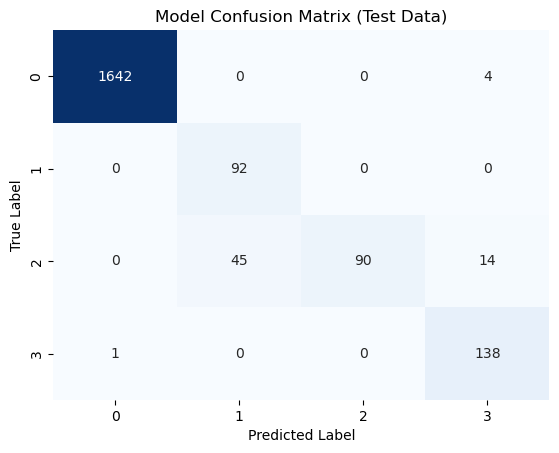

ROC-AUC for test data:


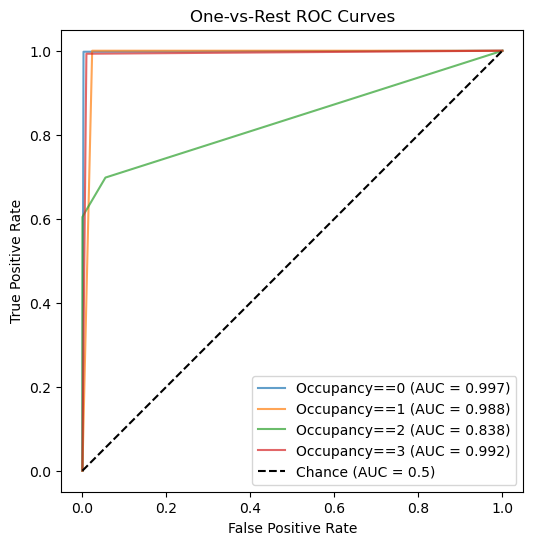

Number of features used in decision tree: 8
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.482020
5,S2_Light,0.249866
13,S5_CO2_Slope,0.117392
6,S3_Light,0.115919
11,S4_Sound,0.012400
9,S2_Sound,0.010455
3,S4_Temp,0.009428
10,S3_Sound,0.002521


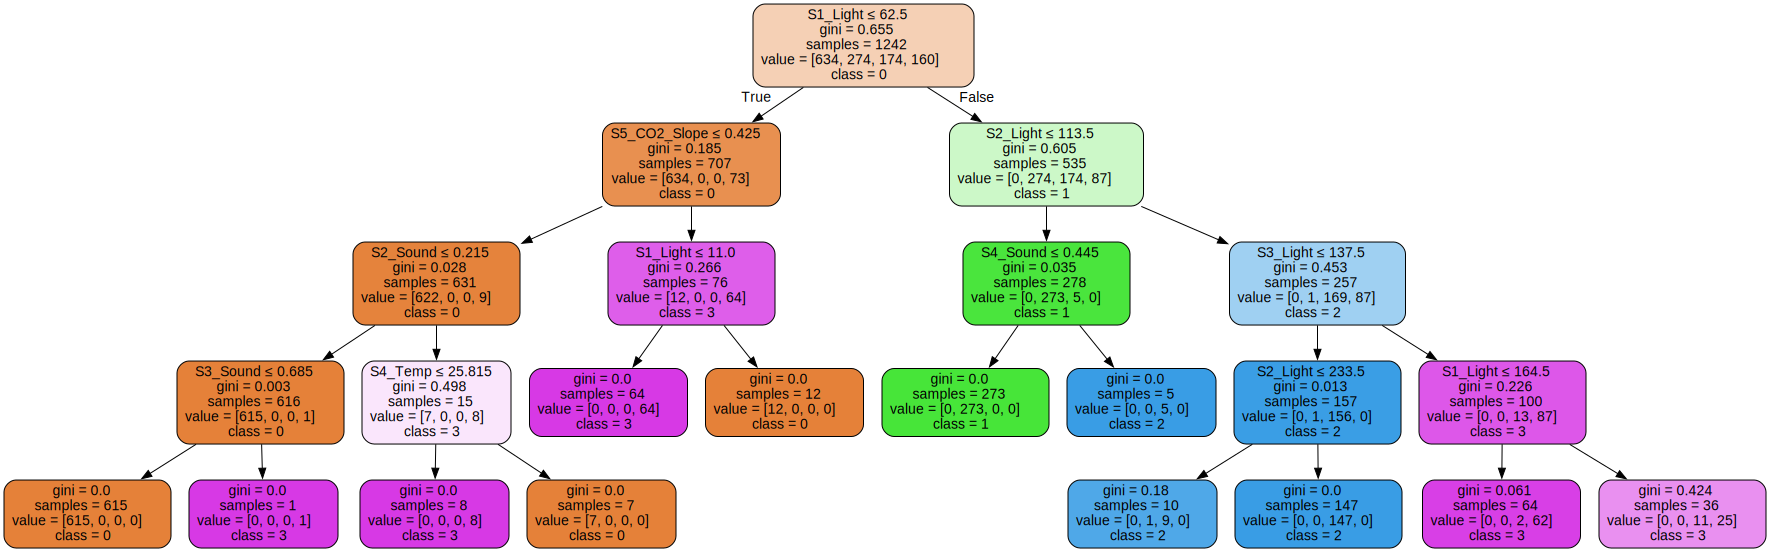

In [38]:
# Instatiate tree classifier
dt_clf = DecisionTreeClassifier(criterion='gini', random_state=888, max_depth=4)

# Fit the model to the training data set 
dt_clf = dt_clf.fit(X_train, y_train)

# Predict the train data and the probabilities
y_train_pred = dt_clf.predict(X_train)
y_train_pred_prob = dt_clf.predict_proba(X_train)

# Predict the validation data and the probabilities
y_val_pred = dt_clf.predict(X_val)
y_val_pred_prob = dt_clf.predict_proba(X_val)

# Predict the test data and the probabilities
y_test_pred = dt_clf.predict(X_test)
y_test_pred_prob = dt_clf.predict_proba(X_test)

# Calculate F1-scores
print('Training Results:')
calculate_f1_scores(y_train, y_train_pred)

print('Validation Results:')
calculate_f1_scores(y_val, y_val_pred)

print('Test Results:')
calculate_f1_scores(y_test, y_test_pred)

# Create and visualize the confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix (Test Data)")
plt.show()

# Display the ROC-AUC Curve for the model
print('ROC-AUC for test data:')
plot_roc(y_test_ohe, y_test_pred_prob)

# Identify and display the features selected by the decision tree model and their importance
df_dt_feature_importance = pd.DataFrame()
df_dt_feature_importance['Feature'] = features
df_dt_feature_importance['Feature Importance'] = dt_clf.feature_importances_
df_dt_feature_importance = df_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_dt_feature_importance = df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in decision tree:', len(df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_dt_feature_importance)

# Use graphviz to visualize the decision tree
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                                feature_names=features,
                                class_names=['0','1','2','3'],
                                filled=True, rounded=True,
                                special_characters=True,
                                # leaves_parallel=True,
                                )
graph = graphviz.Source(dot_data, format='svg')
display(graph)

### Evaluate Decision Tree (combined train and validation dataset)

Combined Training / Validation Results:
F1-Scores
---------
Macro average:    0.9564
Micro average:    0.9826
Weighted average: 0.9826

Test Results:
F1-Scores
---------
Macro average:    0.9650
Micro average:    0.9901
Weighted average: 0.9901



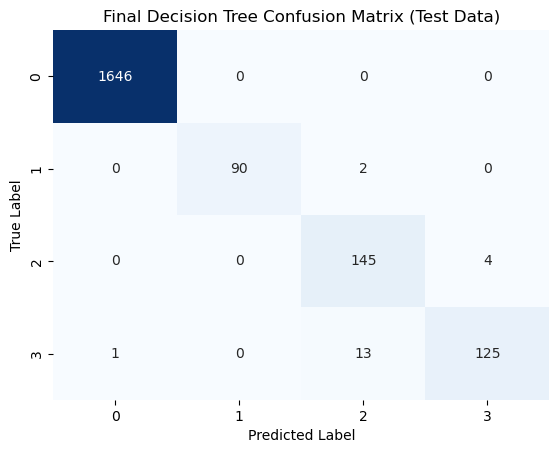

ROC-AUC for test data:


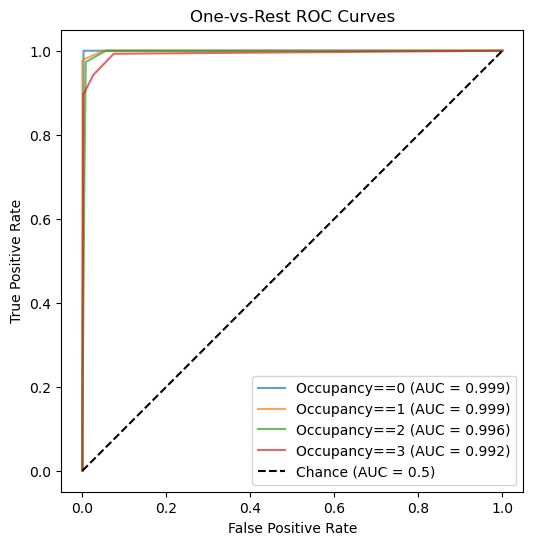

Number of features used in decision tree: 10
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.536108
6,S3_Light,0.151692
13,S5_CO2_Slope,0.109392
12,S5_CO2,0.074716
5,S2_Light,0.068156
1,S2_Temp,0.023768
0,S1_Temp,0.023278
15,S7_PIR,0.010115
8,S1_Sound,0.001434
3,S4_Temp,0.001341


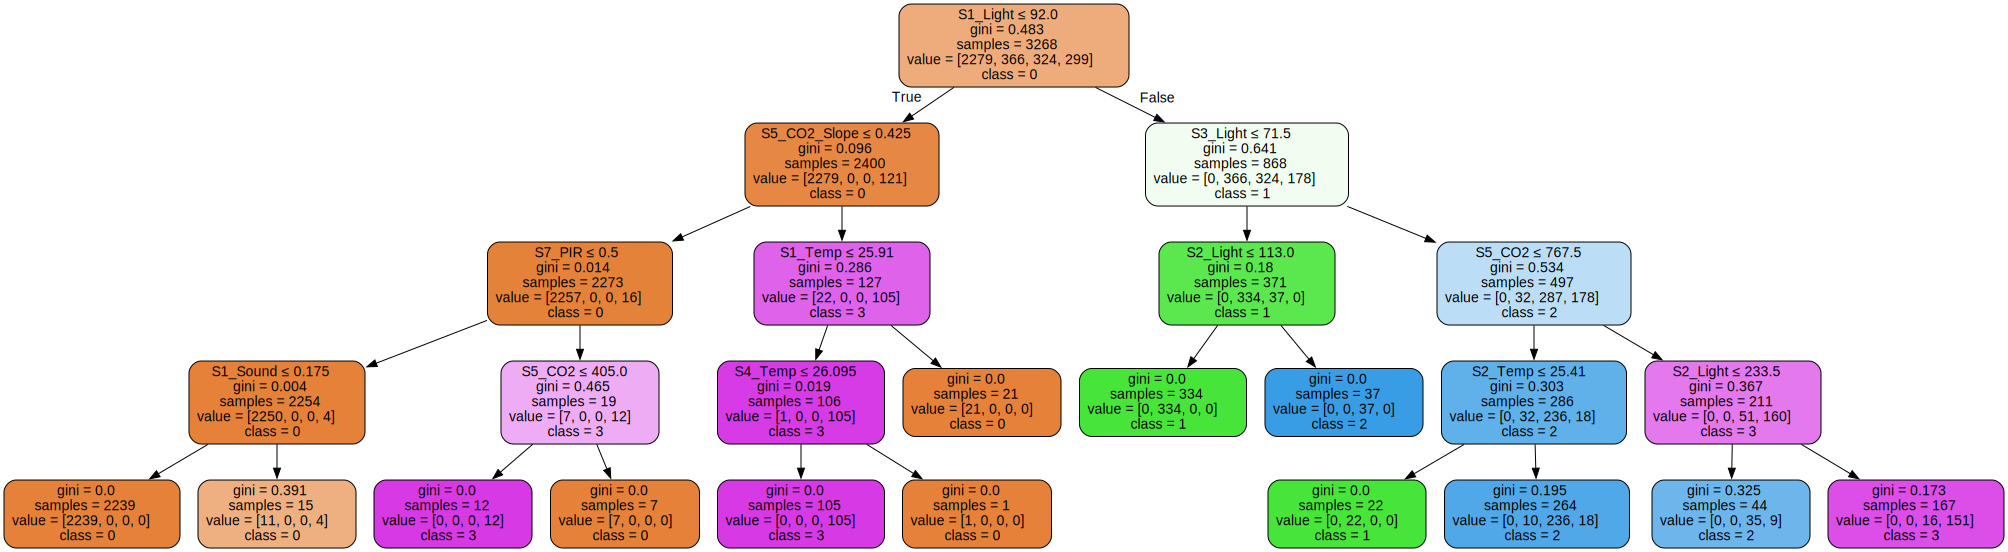

In [39]:
# Instantiate tree classifier
dt_clf = DecisionTreeClassifier(criterion='gini', random_state=888, max_depth=4)

# Fit the model to the combined train_val data set
dt_clf = dt_clf.fit(X_train_val, y_train_val)

# Predict the combined training/validation data and the probabilities
y_train_val_pred = dt_clf.predict(X_train_val)
y_train_val_pred_prob = dt_clf.predict_proba(X_train_val)

# Predict the test data and the probabilities
y_test_pred = dt_clf.predict(X_test)
y_test_pred_prob = dt_clf.predict_proba(X_test)

# Calculate F1-scores
print('Combined Training / Validation Results:')
calculate_f1_scores(y_train_val, y_train_val_pred)

print('Test Results:')
calculate_f1_scores(y_test, y_test_pred)

# Create and visualize the confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Final Decision Tree Confusion Matrix (Test Data)")
plt.show()

# Display the ROC-AUC Curve for the model
print('ROC-AUC for test data:')
plot_roc(y_test_ohe, y_test_pred_prob)

# Identify and display the features selected by the decision tree model and their importance
df_dt_feature_importance = pd.DataFrame()
df_dt_feature_importance['Feature'] = features
df_dt_feature_importance['Feature Importance'] = dt_clf.feature_importances_
df_dt_feature_importance = df_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_dt_feature_importance = df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in decision tree:', len(df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_dt_feature_importance)

# Use graphviz to visualize the decision tree
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                                feature_names=features,
                                class_names=['0','1','2','3'],
                                filled=True, rounded=True,
                                special_characters=True,
                                # leaves_parallel=True,
                                )
graph = graphviz.Source(dot_data, format='svg')
display(graph)

## Gradient Boosted Decision Trees

### Define Gradient Boosted Decision Trees Helper Functions

In [40]:
def get_gboost_decision_tree(learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', max_depth=3, print_output=True):
    """
    Automates the process of creating a gradient boosted decision tree, calculating the f1 scores of the model,
    displaying the model's confusion matrix, identifying the features used in the model and their importance,
    and visualizing the decision tree with graphviz 

    Parameters
    ----------
    learning_rate : float, default=0.1
    n_estimators : int, default=100
        The number of boosting stages to perform. Large number usuall results in better performance
    subsample : float, default=1.0
        The fraction of samples to be used for fitting the individual base learners. If < 1.0 this results in Stochastic Gradient Boosting, leads to reduction of variance and increase in bias.
        Values must be in range (0.0,1.0]
    criterion : str, {'friedman_mse', 'squared_error'}, default='friedman_mse'
        the function to measure the quality of a split.
    max_depth : int or None, default=3
        The maximum depth of a the individual regression estimators. Limits the number of nodes in the tree.
        If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
        Values must be in range [0.0, inf)

    Returns
    -------
    macro_f1_gboost_tree_train : float
        The macro average f1-score for the model when predicting the training data. 
    micro_f1_gboost_tree_train : float
        The micro average f1-score for the model when predicting the training data. 
    weighted_f1_gboost_tree_train: float
        The support weighted average f1-score for the model when predicting the training data.
    macro_f1_gboost_tree_val : float
        The macro average f1-score for the model when predicting the validation data. 
    micro_f1_gboost_tree_val : float
        The micro average f1-score for the model when predicting the validation data. 
    weighted_f1_gboost_tree_val: float
        The support weighted average f1-score for the model when predicting the validation data.   
    """

    learning_rate = learning_rate
    n_estimators = n_estimators
    subsample = subsample
    criterion = criterion
    max_depth = max_depth
    print_output = print_output
    
    gboost_dt_clf = GradientBoostingClassifier(learning_rate = learning_rate,
                                               n_estimators = n_estimators,
                                               subsample = subsample,
                                               criterion = criterion,
                                               max_depth = max_depth,
                                               random_state=888)
    # Fit classifier to X_train and y_train
    gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

    # Predict the training data and probabilities
    y_train_pred = gboost_dt_clf.predict(X_train)
    y_train_pred_prob = gboost_dt_clf.predict_proba(X_train)

    # Predict the validation data and the probabilities
    y_val_pred = gboost_dt_clf.predict(X_val)
    y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

    # Calculate training F1-scores
    print('Training Results:')
    macro_f1_gboost_tree_train, micro_f1_gboost_tree_train, weighted_f1_gboost_tree_train = calculate_f1_scores(y_train, y_train_pred)

    # Calculate validation F1-scores
    print('Validation Results:')
    macro_f1_gboost_tree_val, micro_f1_gboost_tree_val, weighted_f1_gboost_tree_val = calculate_f1_scores(y_val, y_val_pred)

    if print_output:
        # Create and visualize confusion matrix
        sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Model Confusion Matrix")
        plt.show()

        # Identify and display the features selected by the decision tree model and their importance
        df_gboost_dt_feature_importance = pd.DataFrame()
        df_gboost_dt_feature_importance['Feature'] = features
        df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
        df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
        df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
        print('Number of features used in decision tree:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
        print('Features used in the model and their importance:')
        display(df_gboost_dt_feature_importance)

        # Plot final tree
        # gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

    return macro_f1_gboost_tree_train, micro_f1_gboost_tree_train, weighted_f1_gboost_tree_train, macro_f1_gboost_tree_val, micro_f1_gboost_tree_val, weighted_f1_gboost_tree_val

### Gradient Boosted Decision Tree (determine importance of all features with default values)

F1-Scores
---------
Macro average:    0.7328
Micro average:    0.9289
Weighted average: 0.9282



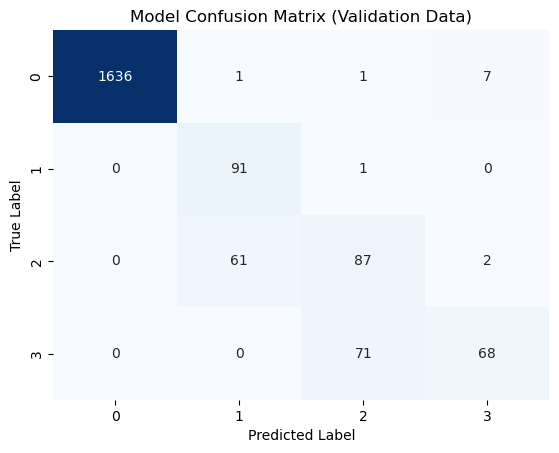

ROC-AUC for validation data:


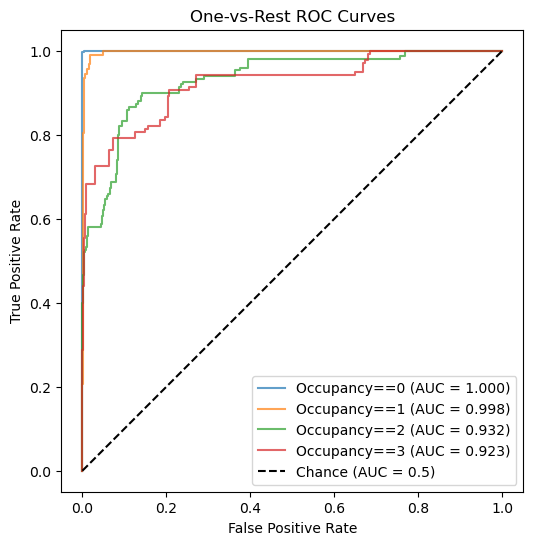

Number of features used in ensemble: 16
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.614144
6,S3_Light,0.121956
5,S2_Light,0.094763
3,S4_Temp,0.059450
13,S5_CO2_Slope,0.059152
7,S4_Light,0.016167
11,S4_Sound,0.013404
1,S2_Temp,0.008007
9,S2_Sound,0.006804
12,S5_CO2,0.002178


In [41]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(#loss = 'log_loss',
                                           #learning_rate = 0.1,
                                           #subsample = 1.0,
                                           #criterion = 'friedman_mse',
                                           #n_estimators = 100,
                                           #max_depth = 3,
                                           #tol = 1e-4,
                                           random_state=888)

# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Calculate F1-scores
macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix (Validation Data)")
plt.show()

# Display the ROC-AUC Curve for the model
print('ROC-AUC for validation data:')
plot_roc(y_val_ohe, y_val_pred_prob)

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)

### Gradient Boosted Decision Tree (tune hyperparameters)
***Warning: below cell takes ~ 34 minutes to run, the output has been saved in a csv and is read into a dataframe in cells below. You do not have to run the below cell that contains the for loop.

In [42]:
# Boolean for whether to run the hyperparameter optimization
RUN_GBTREE_HYPERPARAM_TEST = False

In [43]:
if RUN_GBTREE_HYPERPARAM_TEST:
    # pause printing / output for loop
    _original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    # Create dataframe to store evaluation metrics of each tree iteration
    df_gboost_tree_f1s = pd.DataFrame(columns=['Learning Rate', 'No. Estimators', 'Subsample', 'Criterion', 'Tree Depth', 'Val. Macro F1', 'Val. Micro F1', 'Val. Weighted F1'])

    ## Loop through combos of criterion and max_depth and record macro f1 score on training and validation data to determine optimal values of hyper parameters
    # Create lists for each hyper parameter options
    learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3]
    n_estimators = [50, 100, 150, 200]
    subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    criterion = ['friedman_mse', 'squared_error']
    max_depths = [1, 2, 3, 4]

    # create combinations of all criterion and max_depths
    gboost_param_combos = list(itertools.product(learning_rate, n_estimators, subsample, criterion, max_depths))

    # Instantiate lists to hold results
    train_results = []
    val_results = []

    # Loop through combos, print iteration details, capture f1 scores, add results to lists and dataframe for future analysis
    for combo in gboost_param_combos:
        learning_rate = combo[0]
        n_estimators = combo[1]
        subsample = combo[2]
        criterion = combo[3]
        max_depth = combo[4]
        print('-------------------------------------------------------------------------------------------------------------------------')
        print("==========================")
        print("Hyperparameters")
        print("learning_rate =,", learning_rate)
        print("n_estimators =", n_estimators)
        print("subsample =", subsample)
        print("criterion =", criterion)
        print("max_depth =", max_depth)
        print("==========================")
        macro_f1_gboost_tree_train, micro_f1_gboost_tree_train, weighted_f1_gboost_tree_train, macro_f1_gboost_tree_val, micro_f1_gboost_tree_val, weighted_f1_gboost_tree_val = get_gboost_decision_tree(learning_rate=learning_rate,
                                                                                                                                                                                                        n_estimators=n_estimators,
                                                                                                                                                                                                        subsample=subsample,
                                                                                                                                                                                                        criterion=criterion,
                                                                                                                                                                                                        max_depth=max_depth,
                                                                                                                                                                                                        print_output=False)
        train_results.append(macro_f1_gboost_tree_train)
        val_results.append(macro_f1_gboost_tree_val)
        df_gboost_tree_f1s = pd.concat([df_gboost_tree_f1s, pd.DataFrame([[learning_rate, n_estimators, subsample, criterion, max_depth, macro_f1_gboost_tree_val, micro_f1_gboost_tree_val, weighted_f1_gboost_tree_val]], columns=df_gboost_tree_f1s.columns)], ignore_index=True)

    # reestablish printing / output
    sys.stdout.close()
    sys.stdout = _original_stdout

    ## Save pandas dataframe from hyperparameter tuning above so the file can be read in directly instead of reruning loop
    # Get current working directory for repo
    working_dir = os.getcwd()

    # Save dataframe to csv
    df_gboost_tree_f1s.to_csv(path_or_buf=working_dir+'/data/post_processing/gboost_tree_hyperparameter_tuning.csv', index_label=False)

In [44]:
# Read in df_gboost_tree_f1s dataframe from csv instead of running the loop above ^
df_gboost_tree_f1s = pd.read_csv(working_dir+'/data/post_processing/gboost_tree_hyperparameter_tuning.csv')
# Display dataframe that stores F1-scores from each iteration
display(df_gboost_tree_f1s)

# print best hyper parameters based on maximum macro f1-score
print('Hyper parameters that maximize macro f1-score in gradient boosted decision tree model:')
print(df_gboost_tree_f1s[df_gboost_tree_f1s['Val. Macro F1'] == df_gboost_tree_f1s['Val. Macro F1'].max()].to_string(index=False))



# Output indicates learning_rate=0.2, n_estimators=100, subsample=0.1, max_depth=3 are the optimal hyperparameters.

,Learning Rate,No. Estimators,Subsample,Criterion,Tree Depth,Val. Macro F1,Val. Micro F1,Val. Weighted F1
0,0.010000,50,0.100000,friedman_mse,1,0.538351,0.881046,0.857361
1,0.010000,50,0.100000,friedman_mse,2,0.651494,0.901777,0.882311
2,0.010000,50,0.100000,friedman_mse,3,0.670375,0.905232,0.888664
3,0.010000,50,0.100000,friedman_mse,4,0.682181,0.908193,0.893251
4,0.010000,50,0.100000,squared_error,1,0.538351,0.881046,0.857361
...,...,...,...,...,...,...,...,...
1595,0.300000,200,1.000000,friedman_mse,4,0.724180,0.928924,0.927321
1596,0.300000,200,1.000000,squared_error,1,0.609371,0.769990,0.813324
1597,0.300000,200,1.000000,squared_error,2,0.482236,0.382034,0.471435
1598,0.300000,200,1.000000,squared_error,3,0.649849,0.832675,0.856871


Hyper parameters that maximize macro f1-score in gradient boosted decision tree model:
       Learning Rate  No. Estimators            Subsample    Criterion  Tree Depth        Val. Macro F1        Val. Micro F1     Val. Weighted F1
            0.200000             100             0.100000 friedman_mse           3             0.798598             0.947187             0.945667


### Evaluate Gradient Boosted Decision Tree (train data only)

Training Results:
F1-Scores
---------
Macro average:    0.9552
Micro average:    0.9758
Weighted average: 0.9758

Validation Results:
F1-Scores
---------
Macro average:    0.7986
Micro average:    0.9472
Weighted average: 0.9457

Test Results:
F1-Scores
---------
Macro average:    0.8172
Micro average:    0.9526
Weighted average: 0.9516



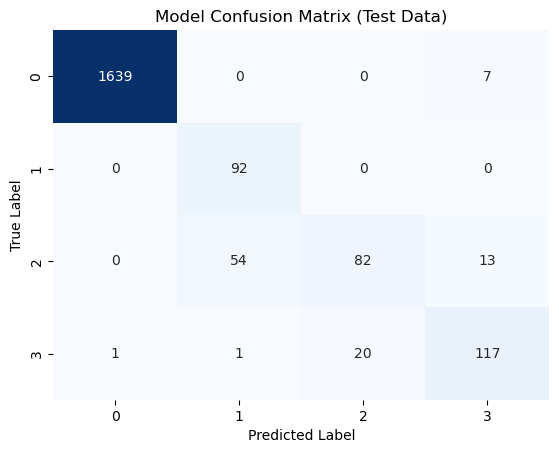

ROC-AUC for test data:


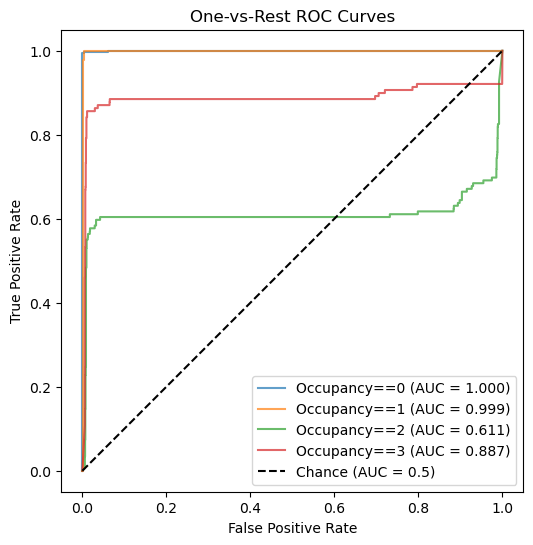

Number of features used in ensemble: 16
Features used in the model and their importance:


,Feature,Feature Importance
7,S4_Light,0.194702
5,S2_Light,0.161601
4,S1_Light,0.146985
6,S3_Light,0.124793
10,S3_Sound,0.086457
13,S5_CO2_Slope,0.049142
11,S4_Sound,0.046418
9,S2_Sound,0.041827
12,S5_CO2,0.032264
8,S1_Sound,0.027751


In [48]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(learning_rate=0.2,
                                           n_estimators=100,
                                           subsample=0.1,
                                           criterion='friedman_mse',
                                           max_depth = 3,
                                           random_state=888)

# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the training data and the probabilities
y_train_pred = gboost_dt_clf.predict(X_train)
y_train_pred_prob = gboost_dt_clf.predict_proba(X_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Predict the test data and the probabilities
y_test_pred = gboost_dt_clf.predict(X_test)
y_test_pred_prob = gboost_dt_clf.predict_proba(X_test)

# Calculate F1-scores
print('Training Results:')
calculate_f1_scores(y_train, y_train_pred)

print('Validation Results:')
calculate_f1_scores(y_val, y_val_pred)

print('Test Results:')
calculate_f1_scores(y_test, y_test_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix (Test Data)")
plt.show()

# Display the ROC-AUC Curve for the model
print('ROC-AUC for test data:')
plot_roc(y_test_ohe, y_test_pred_prob)

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)

### Evaluate Gradient Boosted Decision Tree (combined train and validata data sets)

Combined Training / Validation Results:
F1-Scores
---------
Macro average:    0.9354
Micro average:    0.9737
Weighted average: 0.9738

Test Results:
F1-Scores
---------
Macro average:    0.9370
Micro average:    0.9808
Weighted average: 0.9808



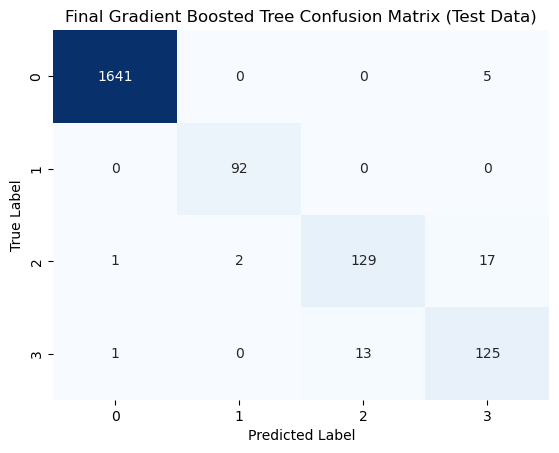

ROC-AUC for test data:


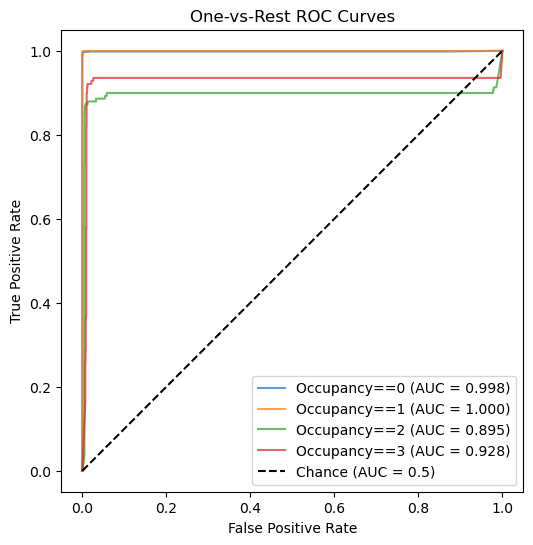

Number of features used in ensemble: 16
Features used in the model and their importance:


,Feature,Feature Importance
8,S1_Sound,0.155418
6,S3_Light,0.148858
10,S3_Sound,0.130893
4,S1_Light,0.118272
9,S2_Sound,0.092261
13,S5_CO2_Slope,0.068327
11,S4_Sound,0.060210
5,S2_Light,0.056190
1,S2_Temp,0.047169
12,S5_CO2,0.043136


In [47]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(learning_rate=0.2,
                                           n_estimators=100,
                                           subsample=0.1,
                                           criterion='friedman_mse',
                                           max_depth = 3,
                                           random_state=888)

# Fit classifier to the combined train_val data set
gboost_dt_clf = gboost_dt_clf.fit(X_train_val, y_train_val)

# Predict the combined training/validation data and the probabilities
y_train_val_pred = gboost_dt_clf.predict(X_train_val)
y_train_val_pred_prob = gboost_dt_clf.predict_proba(X_train_val)

# Predict the test data and the probabilities
y_test_pred = gboost_dt_clf.predict(X_test)
y_test_pred_prob = gboost_dt_clf.predict_proba(X_test)

# Calculate F1-scores
print('Combined Training / Validation Results:')
calculate_f1_scores(y_train_val, y_train_val_pred)

print('Test Results:')
calculate_f1_scores(y_test, y_test_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Final Gradient Boosted Tree Confusion Matrix (Test Data)")
plt.show()

# Display the ROC-AUC Curve for the model
print('ROC-AUC for test data:')
plot_roc(y_test_ohe, y_test_pred_prob)

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)

## Logistic Regression

In [25]:
# Boolean for whether to run the hyperparameter optimization
# The optimization takes about 10 minutes to run
RUN_LR_HYPERPARAM_TEST = False

In [26]:
def build_logistic_regression(optimizer="Adam", learning_rate=0.001, loss_fn="categorical_crossentropy", random_seed=888):
    """
    Builds a logistic regression model with the hyperparameters specified

    Parameters
    ----------
    optimizer : str
        The string identifier of a TensorFlow optimizer
        Default: "Adam"
    learning_rate : float
        The learning rate for the optimizer
        Default: 0.001
    loss_fn : str
        The string identifier of the TensorFlow loss function
        Default: "categorical_crossentropy"
    random_seed : int
        The seed for the random number generator
        Default: 888

    Returns
    -------
    model : tf.keras.Sequential
        An instantiation of a TensorFlow sequential model representing a logistic regression
    """
    # Initialization
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)

    # Build model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=4, activation="softmax"))

    # Initialize optimizer
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.lr.assign(learning_rate)

    # Compile model
    model.compile(
        loss=loss_fn,
        optimizer=optimizer, 
        metrics=[
            tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_macro"),
            tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_micro"),
            tfa.metrics.F1Score(num_classes=4, average="weighted", name="f1_weighted")
        ]
    )
    return model

In [27]:
def build_test_logistic_regression(hyper_params, random_seed=888):
    """
    Wrapper of the "build_logistic_regression" function useful for hyperparameter training

    Parameters
    ----------
    hyper_params : dict
        The dictionary containing hyperparameters with "OPTIMIZER", "LEARNING_RATE",
        "LOSS_FN", and "BATCH_SIZE" as keys
    random_seed : int
        The seed for the random number generator
        Default: 888
    
    Returns
    -------
    f1_scores : tuple
        The macro, micro, and weighted average f1-scores of the model with the
        given hyperparameters
    """
    model = build_logistic_regression(
        optimizer=hyper_params["OPTIMIZER"],
        learning_rate=hyper_params["LEARNING_RATE"],
        loss_fn=hyper_params["LOSS_FN"],
        random_seed=random_seed
    )

    model.fit(
        X_train_std,
        y_train_ohe,
        batch_size=hyper_params["BATCH_SIZE"],
        epochs=1000,
        validation_data=(X_val_std, y_val_ohe),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
        shuffle=True,
        verbose=False
    )

    y_val_pred = np.argmax(model.predict(X_val_std, verbose=1), axis=-1)

    f1_scores = calculate_f1_scores(y_val, y_val_pred, print_output=False)

    return f1_scores

In [28]:
if RUN_LR_HYPERPARAM_TEST:
    # Define the hyperparameter grid space
    OPTIMIZERS = HP_FACTOR("optimizer", ["Adam", "SGD"])
    LEARNING_RATES = HP_FACTOR("learning_rate", [0.001, 0.01, 0.1])
    LOSS_FNS = HP_FACTOR("loss_fn", ["kullback_leibler_divergence", "categorical_crossentropy"])
    BATCH_SIZES = HP_FACTOR("batch_size", [16, 32, 64])

    HP_FACTORS = [OPTIMIZERS, LEARNING_RATES, LOSS_FNS, BATCH_SIZES]
    HP_NAMES = [factor.name for factor in HP_FACTORS]
    HP_VALUES = [factor.values for factor in HP_FACTORS]

    # Iterate over all combinations of hyperparameters and store results
    hp_matrix = itertools.product(*HP_VALUES)
    results = []

    for idx, (optimizer, learning_rate, loss_fn, batch_size) in enumerate(hp_matrix):
        hyper_params = {
            "OPTIMIZER": optimizer,
            "LEARNING_RATE": learning_rate,
            "LOSS_FN": loss_fn,
            "BATCH_SIZE": batch_size
        }
        print(f"--- Starting trial: {idx}")
        print(hyper_params)
        macro_f1, micro_f1, weighted_f1 = build_test_logistic_regression(hyper_params)
        results.append([optimizer, learning_rate, loss_fn, batch_size, macro_f1, micro_f1, weighted_f1])

    # Build dataframe of results for easy model selection
    results = pd.DataFrame(results, columns=HP_NAMES+["macro_f1", "micro_f1", "weighted_f1"])
    results.to_csv("data/post_processing/lr_hyperparam_results.csv")

**Note:** Due to reproducibility issues, the hyperparameter tuning methodology does not always report the same optimal hyperparameter set. By running the hyperparameter selection method multiple times, it was identified that the parameters at trial 10 yield good results.

In [29]:
# Identify best model
if not RUN_LR_HYPERPARAM_TEST:
    results = pd.read_csv("data/post_processing/lr_hyperparam_results.csv", index_col=0)

#best_lr_params = results[results.macro_f1.ge(results.macro_f1.max())].iloc[0]
best_lr_params = results.iloc[10]
best_lr_params

optimizer                            Adam
learning_rate                        0.01
loss_fn          categorical_crossentropy
batch_size                             32
macro_f1                          0.44252
micro_f1                          0.30306
weighted_f1                      0.370559
Name: 10, dtype: object

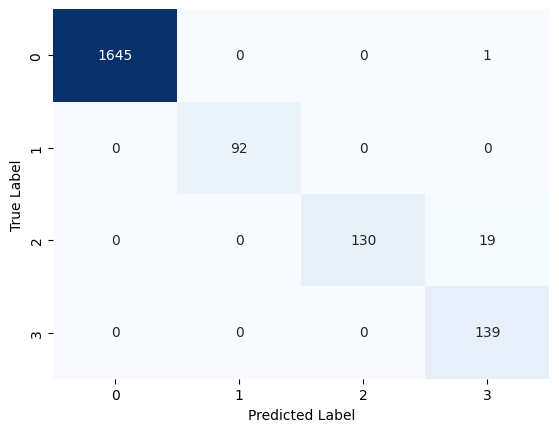

F1-Scores
---------
Macro average:    0.9661
Micro average:    0.9901
Weighted average: 0.9901



In [30]:
# Build and train model using best hyperparameters
model = build_logistic_regression(
    loss_fn=best_lr_params["loss_fn"],
    optimizer=best_lr_params["optimizer"],
    learning_rate=best_lr_params["learning_rate"]
)

history = model.fit(
    X_train_val_std,
    y_train_val_ohe,
    batch_size=best_lr_params["batch_size"],
    epochs=1000,
    validation_data=(X_train_val_test_std, y_test_ohe),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    shuffle=True,
    verbose=False
)

# Make predictions
y_test_pred_prob = model.predict(X_train_val_test_std, verbose=0)
y_test_pred = np.argmax(y_test_pred_prob, axis=-1)

# Display results
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

f1_scores = calculate_f1_scores(y_test, y_test_pred)

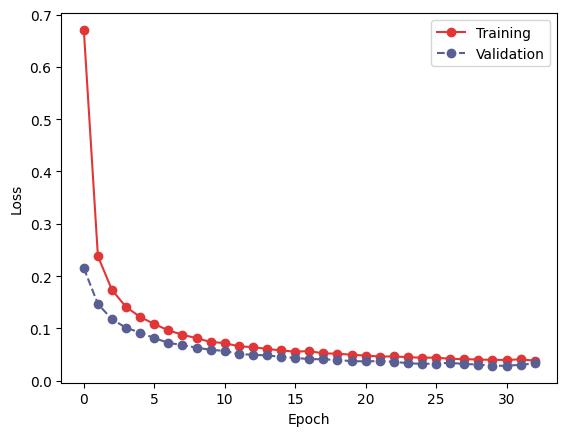

In [31]:
# Display learning curve
history = pd.DataFrame(history.history)
plot_history(history)

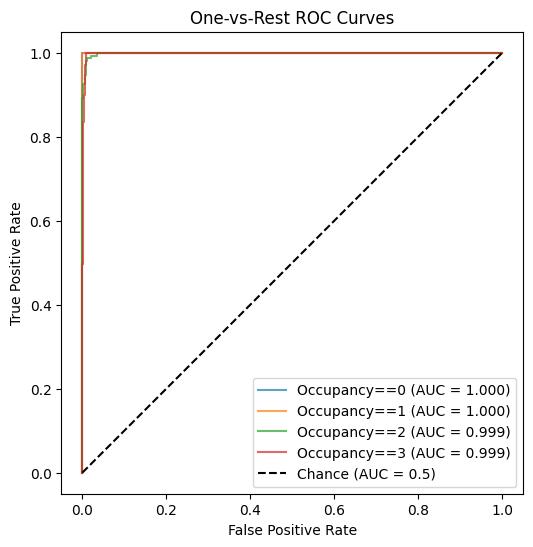

In [32]:
# Display ROC curve
plot_roc(y_test_ohe, y_test_pred_prob)

In [33]:
# Model description
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


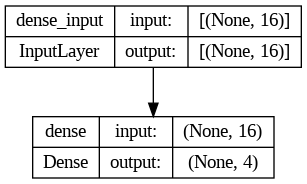

In [34]:
# Model visualization
tf.keras.utils.plot_model(model, show_shapes=True)

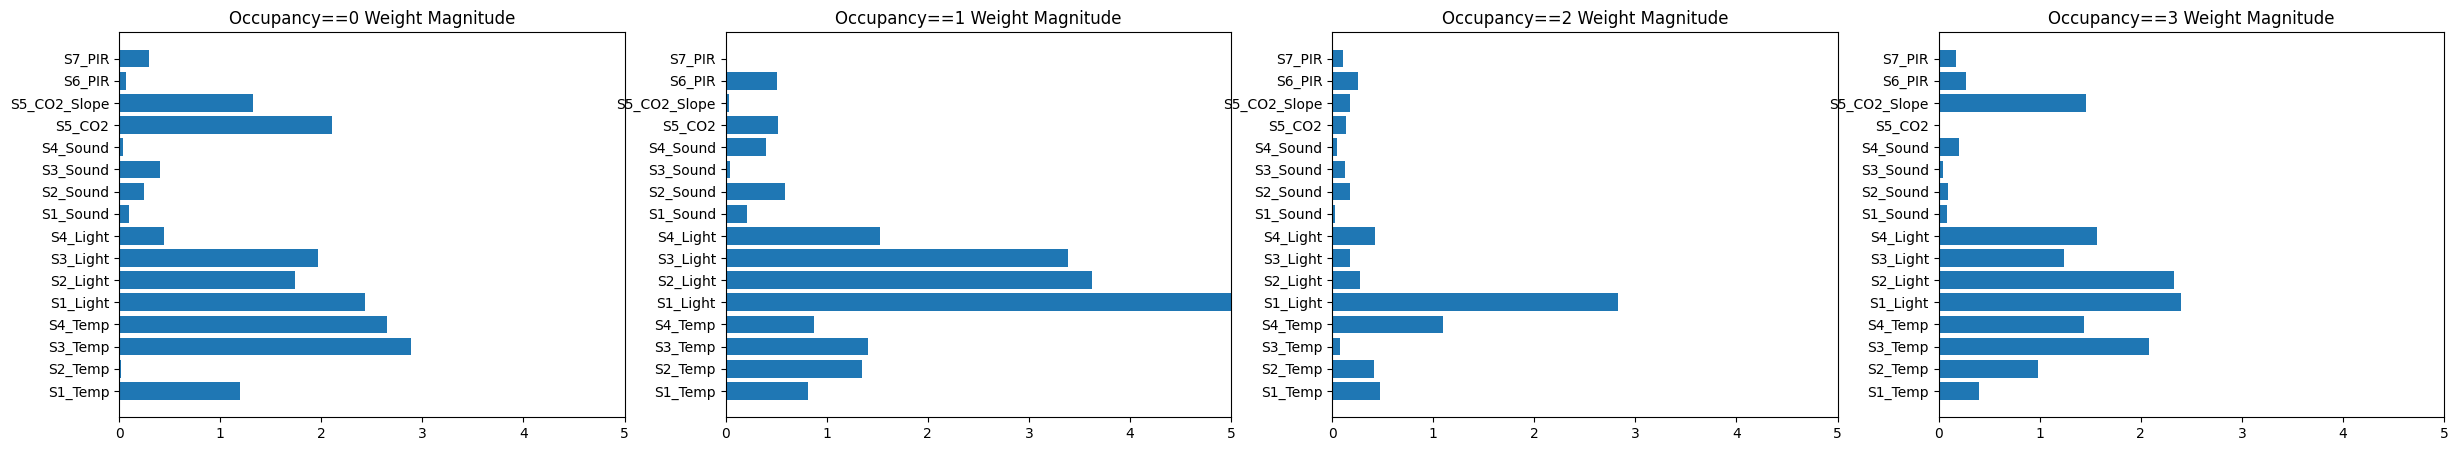

In [35]:
# Weight analysis
weights, biases = model.get_weights()
weights = np.abs(weights)

fig, axes = plt.subplots(1, n_classes, figsize=(30, 5))

for class_id, ax, in enumerate(axes):
    ax.barh(range(len(features)), weights[:,class_id])
    ax.set_yticks(ticks=range(len(features)), labels=features)
    ax.set_title(f"Occupancy=={class_id} Weight Magnitude")
    ax.set_xlim(0, 5)

plt.show()

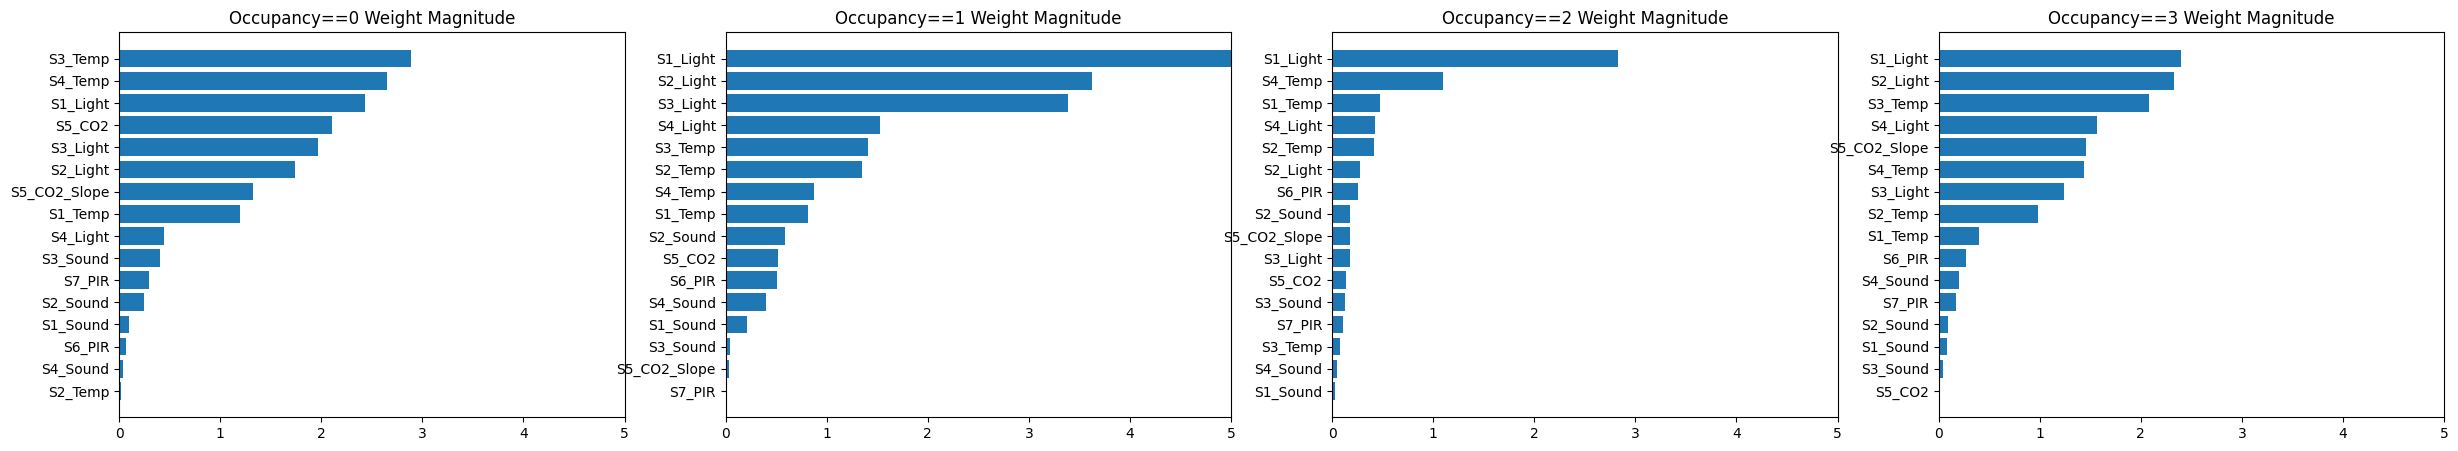

In [36]:
# Sorted weight analysis
fig, axes = plt.subplots(1, n_classes, figsize=(30, 5))

for class_id, ax, in enumerate(axes):
    sort_idx = np.argsort(weights[:,class_id])

    ax.barh(range(len(features)), weights[:,class_id][sort_idx])
    ax.set_yticks(ticks=range(len(features)), labels=features[sort_idx])
    ax.set_title(f"Occupancy=={class_id} Weight Magnitude")
    ax.set_xlim(0, 5)

plt.show()

## Deep Neural Network

In [8]:
# Boolean for whether to run the hyperparameter optimization
# The optimization takes about 10 minutes to run
RUN_NN_HYPERPARAM_TEST = False
RUN_NN_SHAP = False

In [9]:
def build_neural_net(feature_shape = len(features), layer1_units=len(features)*2, layer2 = True, 
                     layer2_units = len(features)/2, layer3 = True, layer3_units = len(features)/4, 
                     layer4 = True, layer4_units = len(features)/8, dropout = False, optimizer="Adam", 
                     learning_rate=0.001, loss_fn="categorical_crossentropy", random_seed=888):
    """
    Builds a logistic regression model with the hyperparameters specified

    Parameters
    ----------
    feature_shape : int
        The shape of the input features
        Default: The length of the set of features
    layer1_units : int
        The number of units for the first hidden layer
        Default: The length of features multiplied by 2
    layer2 : bool
        Whether to include a second hidden layer or not
    layer2_units : int
        The number of units for the second hidden layer
        Default: The length of features divided by 2
    layer3 : bool
        Whether to include a third hidden layer or not
    layer2_units : int
        The number of units for the third hidden layer
        Default: The length of features divided by 4
    layer2 : bool
        Whether to include a fourth hidden layer or not
    layer2_units : int
        The number of units for the fourth hidden layer
        Default: The length of features divided by 8
    dropout : bool
        Whether to include a dropout layer or not
        Default: False
    optimizer : str
        The string identifier of a TensorFlow optimizer
        Default: "Adam"
    learning_rate : float
        The learning rate for the optimizer
        Default: 0.001
    loss_fn : str
        The string identifier of the TensorFlow loss function
        Default: "categorical_crossentropy"
    random_seed : int
        The seed for the random number generator
        Default: 888

    Returns
    -------
    model : tf.keras
        An instantiation of a TensorFlow model representing a neural net
    """
    # Initialization
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)

    # Build model
    # first layer: input
    input1 = tf.keras.layers.Input(shape=(feature_shape,), name='Input')

    # second layer: dense (i.e., the nodes are fully connected)
    input2 = tf.keras.layers.Dense(units=(layer1_units), activation='relu', name='fc_1')(input1)
    
    if layer2:
        # third layer: dense (i.e., the nodes are fully connected)
        input3 = tf.keras.layers.Dense(units=(layer2_units), activation='relu', name='fc_2')(input2)
    else:
        input3 = input2
        
    if layer3 and layer2:
        # fourth layer: dense (i.e., the nodes are fully connected)
        input4 = tf.keras.layers.Dense(units=(layer3_units), activation='relu', name='fc_3')(input3)
    else:
        input4 = input3

    if layer4 and layer3 and layer2:
        # fifth layer: dense (i.e., the nodes are fully connected)
        input5 = tf.keras.layers.Dense(units=(layer4_units), activation='relu', name='fc_4')(input4)
    else:
        input5 = input4

    # set dropout layer if desired, else set last input layer to layer3
    if dropout:
        # sixth layer: dropout
        # makes it so some of the nodes in a given layer don’t pass on their information to the next layer. 
        # This helps with computation time (less parameters) and with overfitting.
        input6 = tf.keras.layers.Dropout(rate=0.3, name='Dropout')(input5)
    else:
        input6 = input5

    #the sixth (and last) layer, which is the output layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # logits = natural logarithm of the odds ratio
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    out = tf.keras.layers.Dense(units=4, activation=None, name='fc_5')(input6)

    # instantiate the model
    model = tf.keras.models.Model(inputs=input1, outputs=out)

    # Initialize optimizer
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.lr.assign(learning_rate)
    
    #Initialize loss function              
        #  because our last layer does not apply sigmoid, by specifying from logits=True, 
        #  the loss function applies the sigmoid function internally it's more efficient 
        #  than doing it manually
    if loss_fn == "categorical_crossentropy":
        loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        
    # Compile model
    model.compile(optimizer=optimizer,
              loss=loss_fn,  

              metrics=['accuracy']) # you can add other metrics here
    model.compile(
        loss=loss_fn,
        optimizer=optimizer, 
        metrics=[
            tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_macro"),
            tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_micro"),
            tfa.metrics.F1Score(num_classes=4, average="weighted", name="f1_weighted")
        ]
    )
    return model

In [10]:
def build_test_neural_net(hyper_params, random_seed=888):
    """
    Wrapper of the "build_logistic_regression" function useful for hyperparameter training

    Parameters
    ----------
    hyper_params : dict
        The dictionary containing hyperparameters with "FEATURE_SHAPE", "LAYER1_UNITS", "LAYER2", "LAYER2_UNITS",
        "DROPOUT", "OPTIMIZER", "LEARNING_RATE", and "LOSS_FN" as keys
    random_seed : int
        The seed for the random number generator
        Default: 888
    
    Returns
    -------
    f1_scores : tuple
        The macro, micro, and weighted average f1-scores of the model with the
        given hyperparameters
    """
    model = build_neural_net(
        feature_shape = hyper_params["FEATURE_SHAPE"],
        layer1_units = hyper_params["LAYER1_UNITS"],
        layer2 = hyper_params["LAYER2"],
        layer2_units = hyper_params["LAYER2_UNITS"],
        layer3 = hyper_params["LAYER3"],
        layer3_units = hyper_params["LAYER3_UNITS"],
        layer4 = hyper_params["LAYER4"],
        layer4_units = hyper_params["LAYER4_UNITS"],
        dropout = hyper_params["DROPOUT"],
        optimizer=hyper_params["OPTIMIZER"],
        learning_rate=hyper_params["LEARNING_RATE"],
        loss_fn=hyper_params["LOSS_FN"],
        random_seed=random_seed
    )

    # set random seed to get reproductible results 
    # neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
    # however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
    tf.random.set_seed(random_seed)
    np.random.seed(random_seed)

    model.fit(X_train_std, tf.one_hot(indices=y_train, depth=4),
                        epochs=1000, 
                        validation_data=(X_val_std, tf.one_hot(indices=y_val, depth=4)),
                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
                        shuffle = True,
                        verbose = False
    )

    y_val_pred = np.argmax(model.predict(X_val_std, verbose=1), axis=-1)

    f1_scores = calculate_f1_scores(y_val, y_val_pred, print_output=False)

    return f1_scores

#### Test Hyperparameters

##### `Test All Combinations`

In [11]:
# This code takes a long time to run
if RUN_NN_HYPERPARAM_TEST:
    # Define the hyperparameter grid space
    hidden_layer_units = [4, 8, 32, 64, 128]
    FEATURE_SHAPE = HP_FACTOR("feature_shape", [len(features)])
    LAYER1_UNITS = HP_FACTOR("layer1_units", hidden_layer_units)
    LAYER2 = HP_FACTOR("layer2", [False, True])
    LAYER2_UNITS = HP_FACTOR("layer2_units", hidden_layer_units)
    LAYER3 = HP_FACTOR("layer3", [False, True])
    LAYER3_UNITS = HP_FACTOR("layer3_units", hidden_layer_units)
    LAYER4 = HP_FACTOR("layer4", [False])
    LAYER4_UNITS = HP_FACTOR("layer4_units", hidden_layer_units)
    DROPOUT = HP_FACTOR("dropout", [False, True])
    OPTIMIZERS = HP_FACTOR("optimizer", ["Adam", "SGD"])
    LEARNING_RATES = HP_FACTOR("learning_rate", [0.001, 0.01, 0.1])
    LOSS_FNS = HP_FACTOR("loss_fn", ["categorical_crossentropy"])

    HP_FACTORS = [FEATURE_SHAPE, LAYER1_UNITS, LAYER2, LAYER2_UNITS, LAYER3, LAYER3_UNITS, LAYER4, LAYER4_UNITS, DROPOUT, OPTIMIZERS, LEARNING_RATES, LOSS_FNS]
    HP_NAMES = [factor.name for factor in HP_FACTORS]
    HP_VALUES = [factor.values for factor in HP_FACTORS]

    # Iterate over all combinations of hyperparameters and store results
    hp_matrix = itertools.product(*HP_VALUES)
    results = []

    for idx, (feature_shape, layer1_units, layer2, layer2_units, layer3, layer3_units, layer4, layer4_units, dropout, optimizer, 
              learning_rate, loss_fn) in enumerate(hp_matrix):
        hyper_params = {
            "FEATURE_SHAPE" : feature_shape,
            "LAYER1_UNITS" : layer1_units,
            "LAYER2" : layer2,
            "LAYER2_UNITS" : layer2_units,
            "LAYER3" : layer3,
            "LAYER3_UNITS" : layer3_units,
            "LAYER4" : layer4,
            "LAYER4_UNITS" : layer4_units,
            "DROPOUT" : dropout,
            "OPTIMIZER": optimizer,
            "LEARNING_RATE": learning_rate,
            "LOSS_FN": loss_fn,
        }
        # do not perform iterations when a higher layer is off
        if not(layer2) and (layer3 or layer4):
            continue
        elif not(layer3) and layer4:
            continue
        # do not repeat iterations for hidden layer sizes when the hidden layer is not included
        elif not(layer2) and layer2_units > min(hidden_layer_units):
            continue
        elif not(layer3) and layer3_units > min(hidden_layer_units):
            continue
        elif not(layer4) and layer4_units > min(hidden_layer_units):
            continue

        print(f"--- Starting trial: {idx}")
        print(hyper_params)
        macro_f1, micro_f1, weighted_f1 = build_test_neural_net(hyper_params)
        results.append([feature_shape, layer1_units, layer2, layer2_units, layer3, layer3_units, layer4, layer4_units,
                        dropout, optimizer, learning_rate, loss_fn, macro_f1, micro_f1, weighted_f1])

    # Build dataframe of results for easy model selection
    results = pd.DataFrame(results, columns=HP_NAMES+["macro_f1", "micro_f1", "weighted_f1"])

In [13]:
# Only run if you have the results from the previous step
if RUN_NN_HYPERPARAM_TEST:
    # Identify best model
    sorted_results = results.sort_values("macro_f1", ascending = False)
    sorted_results = sorted_results[sorted_results["macro_f1"] > 0.80]
    sorted_results

#### `Test Hyperparamters with macro_f1 greater than 0.8`

In [14]:
# This code takes a long time to run
if RUN_NN_HYPERPARAM_TEST:
    # Examine the top results with a macro average greater than 0.8 in further detail
    f1_avg = {}
    for i in range(len(sorted_results)):
        best_lr_params = sorted_results.iloc[i] 
        macro_avg =[]
        for j in range(3):
            # Build and train model using best hyperparameters
            model = build_neural_net(
                feature_shape = best_lr_params["feature_shape"],
                layer1_units = best_lr_params["layer1_units"],
                layer2 = best_lr_params["layer2"],
                layer2_units = best_lr_params["layer2_units"],
                layer3 = best_lr_params["layer3"],
                layer3_units = best_lr_params["layer3_units"],
                layer4 = best_lr_params["layer4"],
                layer4_units = best_lr_params["layer4_units"],
                dropout = best_lr_params["dropout"],
                loss_fn=best_lr_params["loss_fn"],
                optimizer=best_lr_params["optimizer"],
                learning_rate=best_lr_params["learning_rate"]
            )

            history = model.fit(
                np.vstack([X_train_std, X_val_std]),
                tf.one_hot(indices=np.hstack([y_train, y_val]), depth=4),
                epochs=1000,
                validation_split=0.2,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)],
                shuffle=True,
                verbose=False
            )

            # Make predictions
            y_val_pred = np.argmax(model.predict(X_val_std, verbose=0), axis=-1)

            f1_scores = calculate_f1_scores(y_val, y_val_pred, print_output = False)
            macro_avg.append(f1_scores[0])
        f1_avg[i] = np.mean(macro_avg)

In [15]:
# Only run if you have the results from the previous step
if RUN_NN_HYPERPARAM_TEST:
    # Get the true top performers
    # Some hyperparamaters may not be tuned and could have very low scores. We want consistently high average results
    top_params_idx = [idx for idx, val in f1_avg.items() if val >= 0.97]
    sorted_results.iloc[top_params_idx]

#### Further test top 5 results for consistency

In [16]:
# This code takes a long time to run
if RUN_NN_HYPERPARAM_TEST:
    # Examine the top 5 results in further detail
    f1_avg2 = {}
    for i in top_params_idx[:5]:
        best_lr_params = sorted_results.iloc[i] 
        macro_avg =[]
        for j in range(10):
            # Build and train model using best hyperparameters
            model = build_neural_net(
                feature_shape = best_lr_params["feature_shape"],
                layer1_units = best_lr_params["layer1_units"],
                layer2 = best_lr_params["layer2"],
                layer2_units = best_lr_params["layer2_units"],
                layer3 = best_lr_params["layer3"],
                layer3_units = best_lr_params["layer3_units"],
                layer4 = best_lr_params["layer4"],
                layer4_units = best_lr_params["layer4_units"],
                dropout = best_lr_params["dropout"],
                loss_fn=best_lr_params["loss_fn"],
                optimizer=best_lr_params["optimizer"],
                learning_rate=best_lr_params["learning_rate"]
            )

            history = model.fit(
                np.vstack([X_train_std, X_val_std]),
                tf.one_hot(indices=np.hstack([y_train, y_val]), depth=4),
                epochs=1000,
                validation_split=0.2,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)],
                shuffle=True,
                verbose=False
            )

            # Make predictions
            y_val_pred = np.argmax(model.predict(X_val_std, verbose=0), axis=-1)

            f1_scores = calculate_f1_scores(y_val, y_val_pred, print_output = False)
            macro_avg.append(f1_scores[0])
        f1_avg2[i] = np.mean(macro_avg)

In [17]:
# Run this to save the new top params
if RUN_NN_HYPERPARAM_TEST:
    top_params_df = sorted_results.iloc[top_params_idx[:5]].assign(avg_f1=f1_avg2.values()).drop(sorted_results.columns[[12,13,14]], axis = 1)
    top_params_df.to_csv("neural_net_top_params.csv")
    top_params_df

#### `Run the model with the best parameters`

In [18]:
top_params_df = pd.read_csv("data/post_processing/neural_net_top_params.csv")

In [19]:
# use the params with the maximum f1 score
best_lr_params = top_params_df.iloc[top_params_df['avg_f1'].idxmax()]
best_lr_params

Unnamed: 0                            528
feature_shape                          16
layer1_units                            8
layer2                               True
layer2_units                           32
layer3                              False
layer3_units                            4
layer4                              False
layer4_units                            4
dropout                             False
optimizer                            Adam
learning_rate                       0.001
loss_fn          categorical_crossentropy
avg_f1                           0.979063
Name: 1, dtype: object

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 39: early stopping


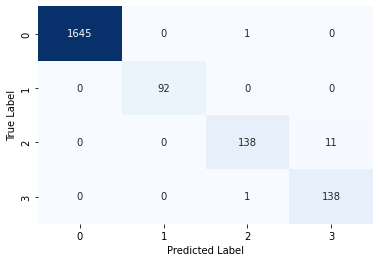

F1-Scores
---------
Macro average:    0.9783
Micro average:    0.9936
Weighted average: 0.9936



In [20]:
# Build and train model using best hyperparameters
model = build_neural_net(
    feature_shape = best_lr_params["feature_shape"],
    layer1_units = best_lr_params["layer1_units"],
    layer2 = best_lr_params["layer2"],
    layer2_units = best_lr_params["layer2_units"],
    layer3 = best_lr_params["layer3"],
    layer3_units = best_lr_params["layer3_units"],
    layer4 = best_lr_params["layer4"],
    layer4_units = best_lr_params["layer4_units"],
    dropout = best_lr_params["dropout"],
    loss_fn=best_lr_params["loss_fn"],
    optimizer=best_lr_params["optimizer"],
    learning_rate=best_lr_params["learning_rate"]
)

history = model.fit(
    np.vstack([X_train_std, X_val_std]),
    tf.one_hot(indices=np.hstack([y_train, y_val]), depth=4),
    epochs=1000,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)],
    shuffle=True,
    verbose=False
)

# Make predictions
y_test_pred = np.argmax(model.predict(X_test_std, verbose=0), axis=-1)

# Display results
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

f1_scores = calculate_f1_scores(y_test, y_test_pred)

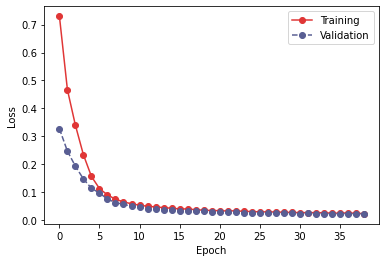

In [21]:
history = pd.DataFrame(history.history)
plot_history(history)

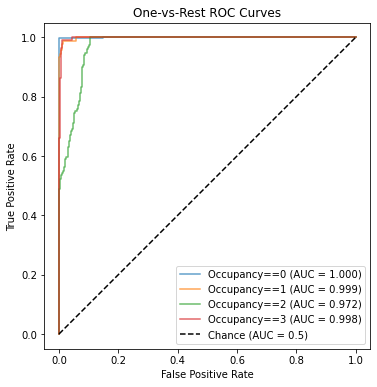

In [22]:
y_test_pred_prob = model.predict(X_train_val_test_std, verbose=0)
plot_roc(y_test_ohe, y_test_pred_prob)

#### `Explain the model with Shap`

In [23]:
# Create proper formatted data frames to pass into Shap
X_df = pd.DataFrame(np.concatenate((X_train_std, X_val_std, X_test_std)), columns = features)
dtypes = X_df.dtypes
X_test_df = pd.DataFrame(X_test_std, columns = features)
for k, v in dtypes.items():
    X_test_df[k] = X_test_df[k].astype(v)

In [ ]:
# This code takes a long time to run
if RUN_NN_SHAP:
    # Fits the explainer
    explainer = shap.Explainer(model.predict, X_test_df)
    # Evaluate SHAP values
    shap_values = explainer.shap_values(X_df)

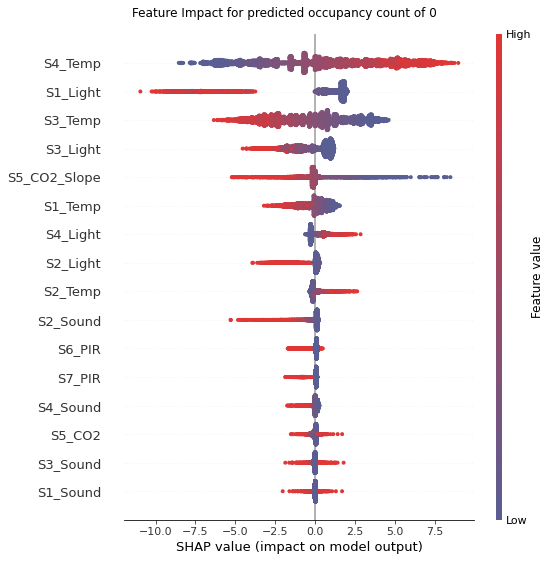

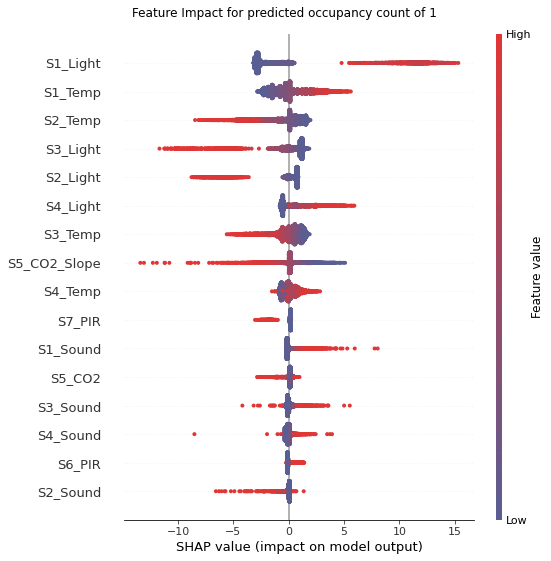

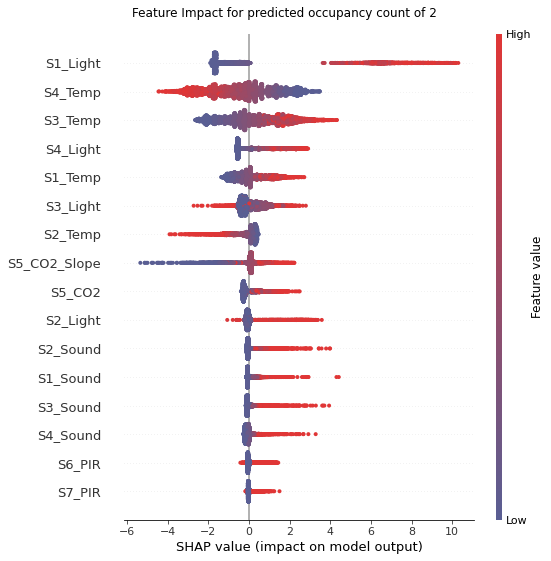

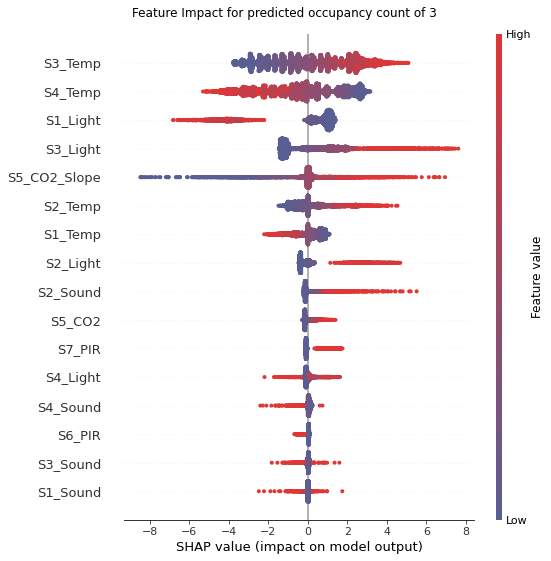

In [44]:
outputs = [0,1,2,3] # list of possible outputs
color_map = LinearSegmentedColormap.from_list("", ['#595e93', '#e03636'])
# Only run this if performing the shapely explanation
if RUN_NN_SHAP:
    for label in outputs:
            plt.suptitle(f'Feature Impact for predicted occupancy count of {label}')
            shap.summary_plot(shap_values[:,:,label],X_df,feature_names=features, cmap = color_map, show=False)
            plt.show()

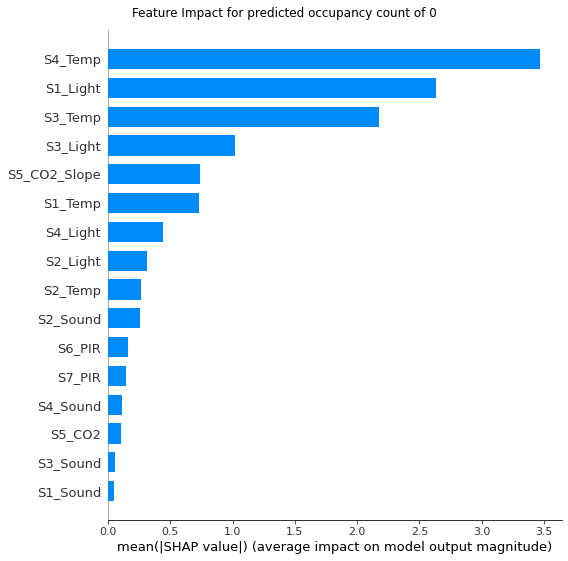

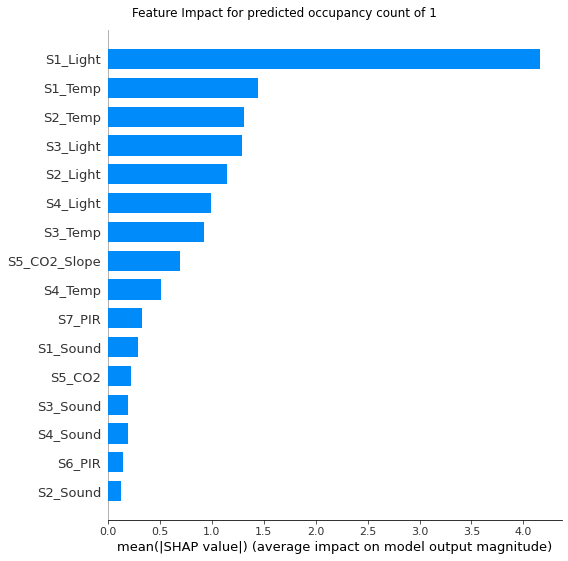

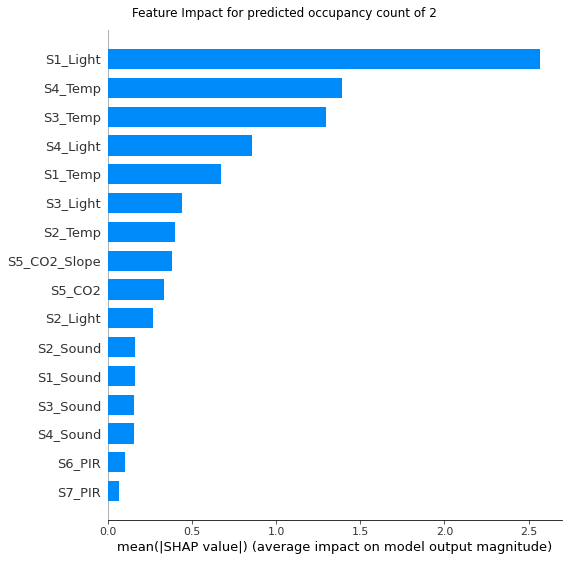

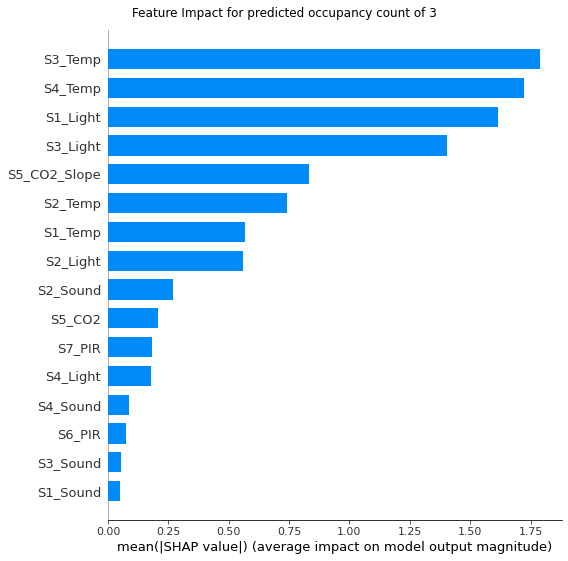

In [43]:
# Only run this if performing the shapely explanation
if RUN_NN_SHAP:
    for label in outputs:
            plt.suptitle(f'Feature Impact for predicted occupancy count of {label}')
            shap.summary_plot(shap_values[:,:,label],X_df,feature_names=features, plot_type = 'bar')

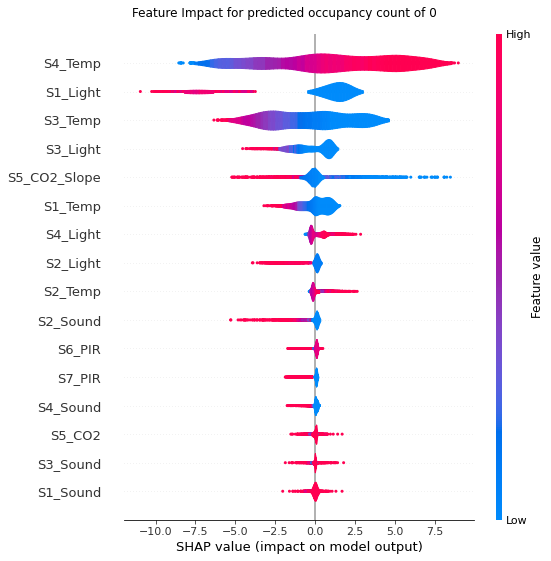

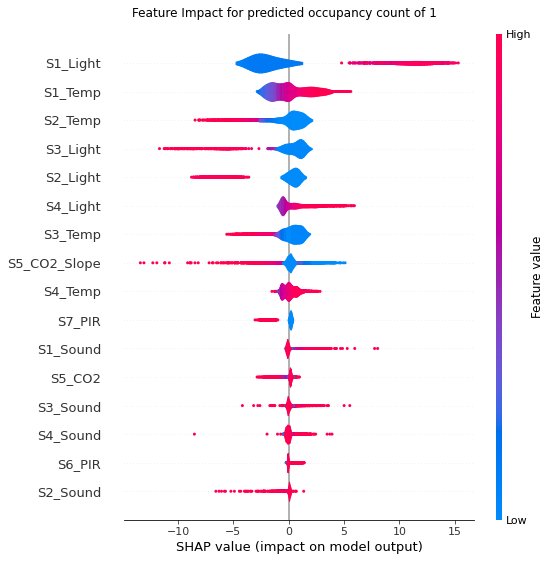

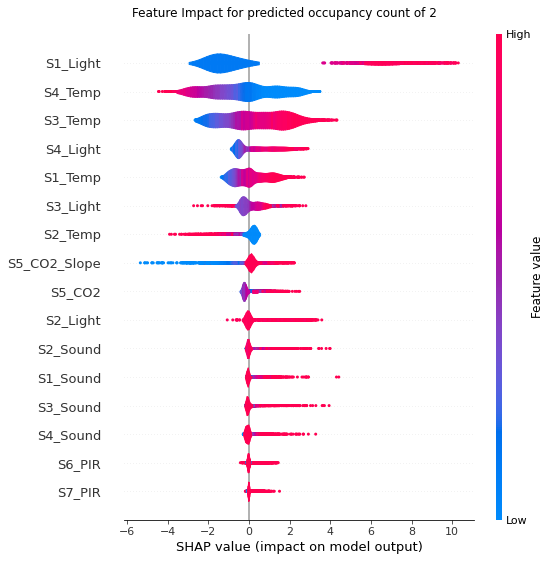

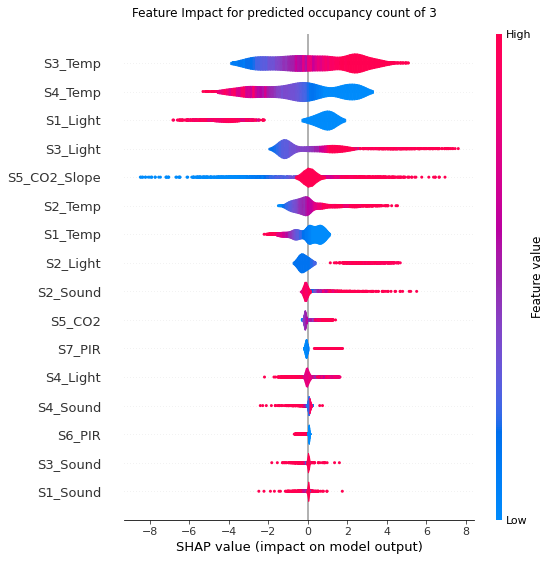

In [42]:
# Only run this if performing the shapely explanation
if RUN_NN_SHAP:
    for label in outputs:
            plt.suptitle(f'Feature Impact for predicted occupancy count of {label}')
            shap.summary_plot(shap_values[:,:,label],X_df,feature_names=features, plot_type = 'violin')